# Importing Modules

In [1]:
# Cleanning
import pandas as pd
import numpy as np
from scipy.stats import mode

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Modelling
from scipy.stats import boxcox
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import (StandardScaler, MinMaxScaler)
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from scipy.stats import iqr
from scipy.stats import scoreatpercentile as pct
from sklearn.cluster import KMeans
from scipy.stats import norm
from scipy.stats import probplot
from math import radians, cos, sin, asin, sqrt
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
import xgboost
import statsmodels.api as sm


 # Units

In [2]:
sqft_to_sqm = (0.3048)**2

# Functions

## Data Cleaning Pipeline Functions

### Importing Data

In [3]:
def load_data(file):

    path = "Data/" + file

    file1 = pd.read_excel(path)

    return file1

### Standardizing Headings

In [4]:
def standard_headings(df):
    """
    Returns a Pandas Dataframe with an standarized heading, i.e lower case and " " replaced by "_"
    
    Parameters
    ----------
    columns_list : Pandas Dataframe

    Returns
    -------
    Returns a Pandas Dataframe with an standarized heading, i.e lower case and " " replaced by "_"

    """  
    heading = df.columns
    df.columns = [clabel.lower().replace(" ", "_") for clabel in heading]
    return df


### Transform yr_built into age

In [5]:
def transform_age(df):

    df["yr_built"] = max(df["yr_built"]) - df["yr_built"]
    df = df.rename(columns={"yr_built":"age"})

    return df

### Transform yr_renovated into binary

In [6]:
def transform_renovated(df):

    df["yr_renovated"] = df["yr_renovated"].where(df["yr_renovated"] == 0, other=1)
    df = df.rename(columns={"yr_renovated":"renovated"})

    return df

### Transform yr_renovated and yr_built into one single column

In [7]:
def transform_renovated_built(df):

    yr_renovated_df = df["yr_renovated"]
    yr_built_df = df["yr_built"]
    yr_ren_built_df = yr_renovated_df.where(yr_renovated_df != 0, other = yr_built_df)
    age_df =  max(yr_ren_built_df) - yr_ren_built_df
    df["yr_built"] = age_df
    df = df.rename(columns={"yr_built":"age"})
    df = df.drop(columns=["yr_renovated"])   

    return df

### Converting to Categorical Type

In [8]:
def obj_to_cat(df, columns_list):

    for column in columns_list:

        df[column] = df[column].astype("category")

    return df

### Removing specific rows

In [9]:
def remove_rows(df):

    df = df[df["bedrooms"] != 33]

    return df

## Data Transformation

### X/y split | Train/test split | Numerical Variables Scaling

In [10]:
def my_transformations(df, test_size=0.2, scaler = "standard"):

    # x-y split

    X = df.drop("price", axis=1)
    y = df["price"]

    # Train/Test Split
    X_train, X_test, y_train, y_test=train_test_split(X, y, test_size= test_size, random_state=0)
    
    
    # Numerical and categorical variables

    X_train_num = X_train._get_numeric_data().reset_index(drop=True)
    X_test_num = X_test._get_numeric_data().reset_index(drop=True)
    X_train_cat = X_train.select_dtypes("category").reset_index(drop=True)
    X_test_cat = X_test.select_dtypes("category").reset_index(drop=True)

    # Numerical Variables Scaling
    
    if scaler != None:
    
        if scaler == "minmax":
    
            scaler = MinMaxScaler()

        elif scaler == "standard":

            scaler = StandardScaler()
    
        scaler.fit(X_train_num)
        X_train_num_scaled = pd.DataFrame(scaler.transform(X_train_num), columns=X_train_num.columns).reset_index(drop=True)
        X_test_num_scaled = pd.DataFrame(scaler.transform(X_test_num), columns=X_test_num.columns).reset_index(drop=True)
    
        return {"train":[X_train_num_scaled, X_train_cat, y_train], "test":[X_test_num_scaled, X_test_cat, y_test]}

    return {"train":[X_train_num, X_train_cat, y_train], "test":[X_test_num, X_test_cat, y_test]}

### Normalization

In [11]:
def var_normalization(df):    

    transformer = PowerTransformer(method="box-cox").fit(df.to_numpy().reshape(-1,1))
    power_norm = transformer.transform(df.to_numpy().reshape(-1,1))
    power_norm = pd.DataFrame(power_norm)[0]

    return (transformer, power_norm)

## Regression Functions

### Predict, generate metrics and plot

In [237]:

def prediction_plot(model, X, y, set="test", y_transformer = None):

    # Predict
    y_pred = model.predict(X)

    # Do the inverse normal transformation to return the dependent variable to meaningfull values
    if y_transformer != None:

        if y_transformer != "log":

            y = pd.DataFrame(y_transformer.inverse_transform(np.array(y).reshape(-1, 1)))[0]
            y_pred = pd.DataFrame(y_transformer.inverse_transform(y_pred.reshape(-1, 1)))[0]
        
        elif y_transformer == "log":

            y = np.exp(y)
            y_pred = np.exp(y_pred)


    result = pd.DataFrame({f"y_{set}":y, "y_pred":y_pred})

    # Metrics
    
    R2 = r2_score(y, y_pred)
    RMSE = mse(y, y_pred, squared=False)
    R2_adj = R2_adjusted(X, y, y_pred, R2)
    metrics = {"MSE":mse(y, y_pred), "RMSE":RMSE, "MAE":mae(y, y_pred), "R2":R2, "R2_adj":R2_adj}

    print(f"The model performance for the {set} set")
    print("-------------------------------------------")
    print(f"RMSE of {set} set is {RMSE}")
    print(f"Adjusted R2 score of {set} set is {R2_adj}")

    # Plots

    fig, axs = plt.subplots(1,3,figsize=(15,5))

    fs = 11
    
    plt.xticks(fontsize = fs)

    sns.regplot(x=f"y_{set}", y="y_pred", data=result, scatter_kws={"color": "red"}, line_kws={"color": "black"}, ax=axs[0])
    sns.histplot(y-y_pred, kde=True, ax=axs[1])
    axs[2].plot(y_pred,y - y_pred,"o")
    axs[2].plot(y_pred,np.zeros(len(y_pred)),linestyle='dashed')

    axs[0].set_title(f"y_{set}".capitalize() + " Set - Observed VS Predicted", fontsize = fs)
    axs[1].set_title(f"y_{set}".capitalize() + " Set - Histogram of the Residuals", fontsize = fs)
    axs[1].set_xlabel(f"y_{set}" + " - y_pred", fontsize = fs)
    axs[2].set_xlabel("Predicted", fontsize = fs)
    axs[2].set_ylabel("Residuals", fontsize = fs)
    axs[2].set_title("Residuals by Predicted", fontsize = fs)

    return {"Result":result, "Metrics":metrics, "Figure": (fig, axs)}


### Linear Regression

In [13]:


def my_linear_regression(X_train, y_train, X_test, y_test):

    # Model Fit
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Evaluation on the Train Set
    train = prediction_plot(model, X_train, y_train, set="train")

    print()

    # Evaluation on the Test Set
    test = prediction_plot(model, X_test, y_test, set="test")

    return {"Model":model, "Train":train, "Test":test}




# def my_linear_regression(X_train, y_train, X_test, y_test):

#     # Model Fit
#     model = LinearRegression()
#     model.fit(X_train, y_train)
#     coefficients = list(model.coef_)

#     # Predict
#     y_pred = model.predict(X_test)
#     result = pd.DataFrame({"y_test":y_test, "y_pred":y_pred})

#     # Metrics
    
#     R2 = r2_score(y_test, y_pred)
#     metrics = {"MSE":mse(y_test, y_pred), "RMSE":mse(y_test, y_pred, squared=False), "MAE":mae(y_test, y_pred), "R2":R2, "R2_adj":R2_adjusted(X_test, y_test, y_pred, R2)}

#     # Plots

#     fig, axs = plt.subplots(1,3,figsize=(30,10))

#     sns.regplot(x="y_test", y="y_pred", data=result, scatter_kws={"color": "red"}, line_kws={"color": "black"}, ax=axs[0])
#     sns.histplot(y_test-y_pred, kde=True, ax=axs[1])
#     axs[2].plot(y_pred,y_test - y_pred,"o")
#     axs[2].plot(y_pred,np.zeros(len(y_pred)),linestyle='dashed')

#     axs[0].set_title("Test Set - Observed VS Predicted")
#     axs[1].set_title("Test Set - Histogram of the Residuals")
#     axs[1].set_xlabel("y_test - y_pred")
#     axs[2].set_xlabel("predited")
#     axs[2].set_ylabel("residuals")
#     axs[2].set_title("Residuals by Predicted")
    


#     # Output
    
#     return {"Fitting Coefficients":coefficients, "Result":result, "Metrics":metrics, "Figure": (fig, axs)}

### Flexible Method Regression

In [14]:
def my_flex_regression(X_train, y_train, X_test, y_test, model, y_transformer, **kwargs):

    # Model Fit
    model.set_params(**kwargs)
    model.fit(X_train, y_train)

    # Evaluation on the Train Set
    train = prediction_plot(model, X_train, y_train, set="train", y_transformer = y_transformer)

    print()

    # Evaluation on the Test Set
    test = prediction_plot(model, X_test, y_test, set="test", y_transformer = y_transformer)

    return {"Model":model, "Train":train, "Test":test}

## Plotting

In [15]:
def my_correlation_heatmap(df, figsize = (16,16)): 

    # correlation matrix

    correlation_matrix = df.corr()

    # create figure and axes
    fig, ax = plt.subplots(figsize = figsize)

    # set title
    ax.set_title('Correlation Heatmap', fontweight='bold')


    sns.heatmap(correlation_matrix,  # the data for the heatmap
                annot=True,  # show the actual values of correlation
                cmap='seismic',  # provide the 'seismic' colormap
                center=0,  # specify the value at which to center the colormap
                )

## Utility Functions

In [16]:
# Function to store in dictionary the number of nan values per column

def nan_counter(df):
    
    """
    Returns a dictionary containing the number of nan values per column (for dataframe df)

    Parameters
    ----------
    df : Pandas dataframe

    Returns
    -------
    remaining_nan : Dictionary
        Contains the number of nan values in each column of the dataframe

    """
    
    remaining_nan = {}

    for column in df.columns:

        remaining_nan[column] = df[column][df[column].isna() == True].size

    return remaining_nan

In [17]:
def R2_adjusted(X, y, y_pred, R2=None):
    
    if R2==None:
    
        R2 = r2_score(y, y_pred)
    
    else:
        R2_adj = 1 - (1-R2)*(len(y)-1)/(len(y)-X.shape[1]-1)

    return R2_adj

In [18]:
# from haversine import haversine, Unit
# https://pypi.org/project/haversine/


def haversine(list_long_lat, other=[-122.336283, 47.609395]):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees), in this case the 2nd point is in the 
    Pike Pine Retail Core of Seattle, WA.
    """
    lon1, lat1 = list_long_lat[0], list_long_lat[1]
    lon2, lat2 = other[0], other[1]
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371 * c
    return km

# Pipeline Controller

In [19]:
# Inputs for the Pipeline Controller

drop_columns = ["id", "date","sqft_lot", "sqft_above", "sqft_basement", "sqft_lot15", "condition"]
# bucket_columns = ["st", "gender"]
# clean_columns_NaN = ["customer_lifetime_value", "income", "monthly_premium_auto", "number_of_open_complaints", "total_claim_amount"]
# clean_columns_zeros = ["income"]
# clean_columns_cat = [("gender", "U")]
# int_columns = ["customer_lifetime_value", "income", "monthly_premium_auto", "number_of_open_complaints", "total_claim_amount"]
cat_columns = ['waterfront', 'view', 'grade']

# bucketing_dict = {"F":"F", "female":"F", "Femal":"F"
#                  ,"M":"M", "Male":"M"
#                  ,"California": "California", "Cali": "California"
#                  ,"Arizona":"Arizona","AZ":"Arizona"
#                  ,"Washington":"Washington", "WA":"Washington"
#                  ,"Oregon":"Oregon"
#                  ,"Nevada":"Nevada"
#                  ,np.nan:np.nan
#                  }

In [20]:
hp_df = (load_data("Data_MidTerm_Project_Real_State_Regression.xls")
.pipe(standard_headings)
.drop(drop_columns, axis=1)
.pipe(transform_renovated_built)
# .pipe(transform_age)
# .pipe(transform_renovated)
# .pipe(dt_corrector)
# .pipe(bucket_series, bucket_columns, bucketing_dict)
# .drop_duplicates().reset_index(drop=True)
# .pipe(replace_by, clean_columns_NaN)
# .pipe(replace_by, clean_columns_zeros)
# .pipe(replace_by_cat, clean_columns_cat)
# .dropna()
# .pipe(standardize_data)
# .pipe(float_to_int, float_columns)
.pipe(obj_to_cat, cat_columns)
.pipe(remove_rows)
.reset_index(drop=True)
)

In [21]:
hp_df

,bedrooms,bathrooms,sqft_living,floors,waterfront,view,grade,age,zipcode,lat,long,sqft_living15,price
0,3,1.00,1180,1.0,0,0,7,60,98178,47.5112,-122.257,1340,221900
1,3,2.25,2570,2.0,0,0,7,24,98125,47.7210,-122.319,1690,538000
2,2,1.00,770,1.0,0,0,6,82,98028,47.7379,-122.233,2720,180000
3,4,3.00,1960,1.0,0,0,7,50,98136,47.5208,-122.393,1360,604000
4,3,2.00,1680,1.0,0,0,8,28,98074,47.6168,-122.045,1800,510000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21591,3,2.50,1530,3.0,0,0,8,6,98103,47.6993,-122.346,1530,360000
21592,4,2.50,2310,2.0,0,0,8,1,98146,47.5107,-122.362,1830,400000
21593,2,0.75,1020,2.0,0,0,7,6,98144,47.5944,-122.299,1020,402101
21594,3,2.50,1600,2.0,0,0,8,11,98027,47.5345,-122.069,1410,400000


# Initial Data Exploration

In [22]:
hp_df = (load_data("Data_MidTerm_Project_Real_State_Regression.xls")
.pipe(standard_headings)
)

In [23]:
hp_df

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
0,7129300520,2014-10-13,3,1.00,1180,5650,1.0,0,0,3,...,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,221900
1,6414100192,2014-12-09,3,2.25,2570,7242,2.0,0,0,3,...,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,538000
2,5631500400,2015-02-25,2,1.00,770,10000,1.0,0,0,3,...,770,0,1933,0,98028,47.7379,-122.233,2720,8062,180000
3,2487200875,2014-12-09,4,3.00,1960,5000,1.0,0,0,5,...,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,604000
4,1954400510,2015-02-18,3,2.00,1680,8080,1.0,0,0,3,...,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,510000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,2014-05-21,3,2.50,1530,1131,3.0,0,0,3,...,1530,0,2009,0,98103,47.6993,-122.346,1530,1509,360000
21593,6600060120,2015-02-23,4,2.50,2310,5813,2.0,0,0,3,...,2310,0,2014,0,98146,47.5107,-122.362,1830,7200,400000
21594,1523300141,2014-06-23,2,0.75,1020,1350,2.0,0,0,3,...,1020,0,2009,0,98144,47.5944,-122.299,1020,2007,402101
21595,291310100,2015-01-16,3,2.50,1600,2388,2.0,0,0,3,...,1600,0,2004,0,98027,47.5345,-122.069,1410,1287,400000


In [24]:
hp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             21597 non-null  int64         
 1   date           21597 non-null  datetime64[ns]
 2   bedrooms       21597 non-null  int64         
 3   bathrooms      21597 non-null  float64       
 4   sqft_living    21597 non-null  int64         
 5   sqft_lot       21597 non-null  int64         
 6   floors         21597 non-null  float64       
 7   waterfront     21597 non-null  int64         
 8   view           21597 non-null  int64         
 9   condition      21597 non-null  int64         
 10  grade          21597 non-null  int64         
 11  sqft_above     21597 non-null  int64         
 12  sqft_basement  21597 non-null  int64         
 13  yr_built       21597 non-null  int64         
 14  yr_renovated   21597 non-null  int64         
 15  zipcode        2159

In [25]:
hp_df.describe()

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
count,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,2.159700e+04
mean,4.580474e+09,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.007547,0.234292,3.409825,7.657915,1788.596842,291.725008,1970.999676,84.464787,98077.951845,47.560093,-122.213982,1986.620318,12758.283512,5.402966e+05
std,2.876736e+09,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.086549,0.766390,0.650546,1.173200,827.759761,442.667800,29.375234,401.821438,53.513072,0.138552,0.140724,685.230472,27274.441950,3.673681e+05
min,1.000102e+06,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000,7.800000e+04
25%,2.123049e+09,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000,3.220000e+05
50%,3.904930e+09,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000,4.500000e+05
75%,7.308900e+09,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000,6.450000e+05
max,9.900000e+09,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000,7.700000e+06


In [26]:
hp_df_shape = hp_df.shape
hp_df_shape

(21597, 21)

In [27]:
nan_counter(hp_df)

{'id': 0,
 'date': 0,
 'bedrooms': 0,
 'bathrooms': 0,
 'sqft_living': 0,
 'sqft_lot': 0,
 'floors': 0,
 'waterfront': 0,
 'view': 0,
 'condition': 0,
 'grade': 0,
 'sqft_above': 0,
 'sqft_basement': 0,
 'yr_built': 0,
 'yr_renovated': 0,
 'zipcode': 0,
 'lat': 0,
 'long': 0,
 'sqft_living15': 0,
 'sqft_lot15': 0,
 'price': 0}

In [28]:
hp_df.drop_duplicates().shape

(21597, 21)

In [29]:
dep_var = hp_df["price"]

## Price Analysis

### Description and Distribution

In [30]:
# Descriptive statistics summary
dep_var.describe()

count    2.159700e+04
mean     5.402966e+05
std      3.673681e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

C:\Users\ehern\miniconda3\envs\DA_Environment\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price', ylabel='Density'>

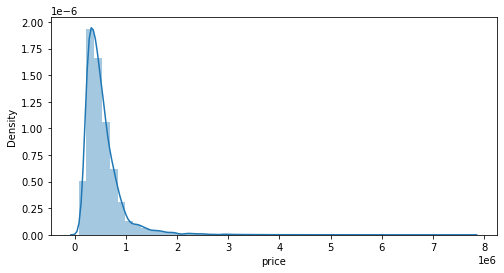

In [31]:
# Histogram

# create figure and axes
fig, ax = plt.subplots(figsize = (8,4))

sns.distplot(dep_var)

In [32]:
# Skewness and Kurtosis
print(f"Skewness: {dep_var.skew()}")
print(f"Kurtosis: {dep_var.kurt()}")

Skewness: 4.023364652271239
Kurtosis: 34.54135857673376


C:\Users\ehern\miniconda3\envs\DA_Environment\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='price'>

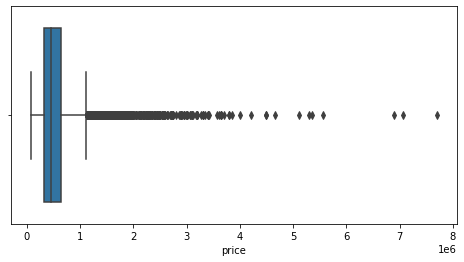

In [33]:
# Boxplot

# create figure and axes
fig, ax = plt.subplots(figsize = (8,4))

sns.boxplot(dep_var)

### Feature Correlations with Price

In [34]:
hp_df.columns

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'price'],
      dtype='object')

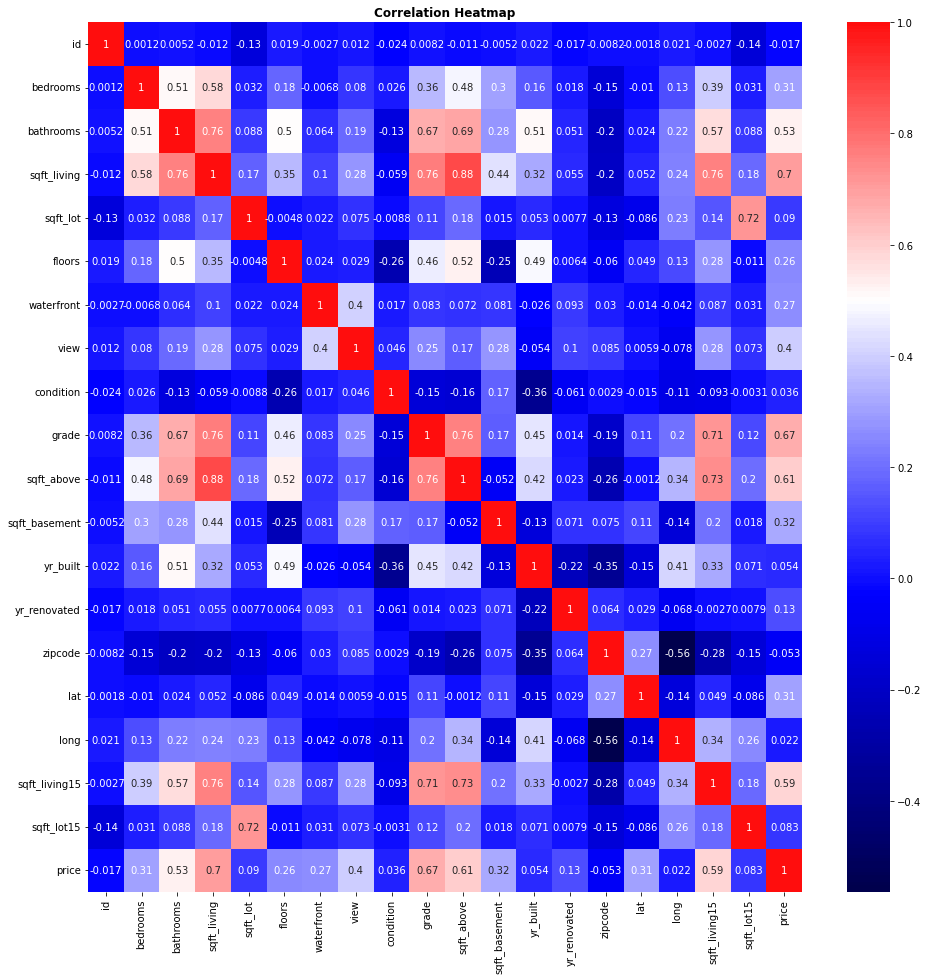

In [35]:
my_correlation_heatmap(hp_df, figsize=(16,16))

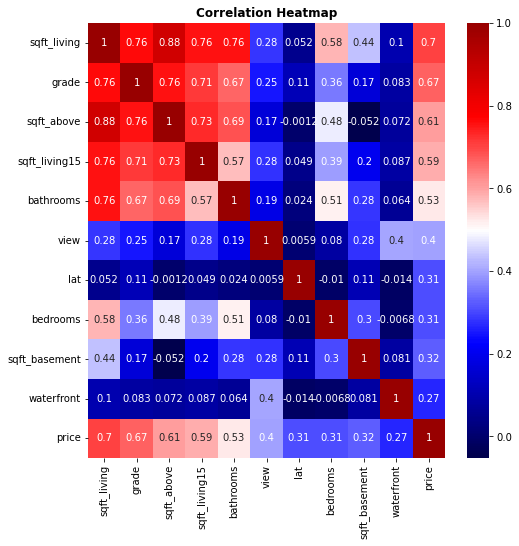

In [36]:
my_correlation_heatmap(hp_df[['sqft_living', 'grade', 'sqft_above','sqft_living15','bathrooms','view', 'lat', 'bedrooms', 'sqft_basement','waterfront','price']], figsize=(8,8))

<AxesSubplot:xlabel='sqft_living', ylabel='price'>

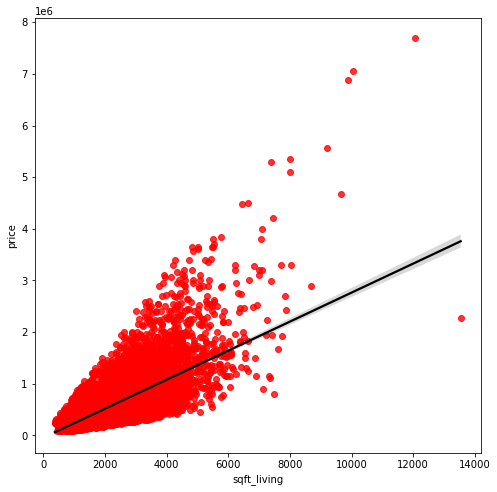

In [37]:
# Scatter plot with sqft_living
var = 'sqft_living'
data = pd.concat([dep_var, hp_df[var]], axis=1)

fig, ax = plt.subplots(figsize = (8,8))
sns.regplot(x=var, y="price", data=data, scatter_kws={"color": "red"}, line_kws={"color": "black"})


<AxesSubplot:xlabel='sqft_living15', ylabel='price'>

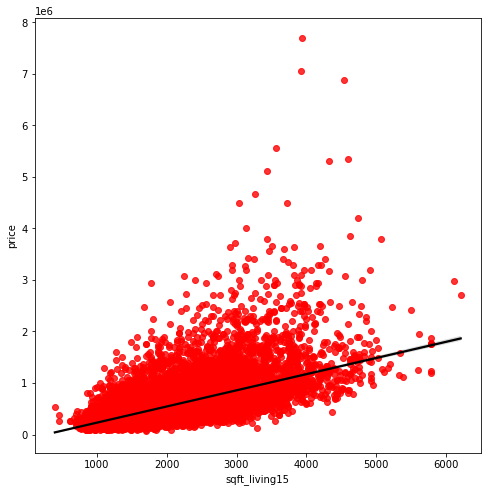

In [38]:
# Scatter plot with sqft_living15
var = 'sqft_living15'
data = pd.concat([dep_var, hp_df[var]], axis=1)

fig, ax = plt.subplots(figsize = (8,8))
sns.regplot(x=var, y="price", data=data, scatter_kws={"color": "red"}, line_kws={"color": "black"})


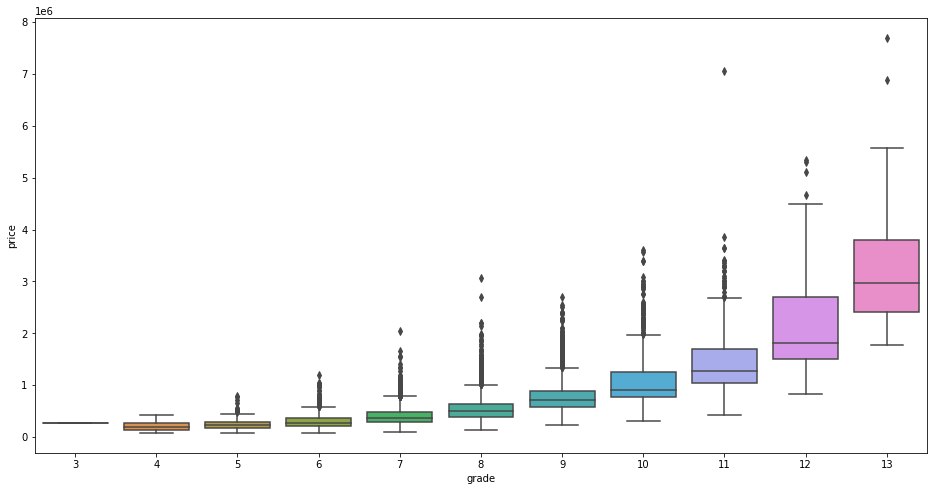

In [39]:
#box plot grade/saleprice
var = 'grade'
data = pd.concat([dep_var, hp_df[var]], axis=1)
fig, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="price", data=data)

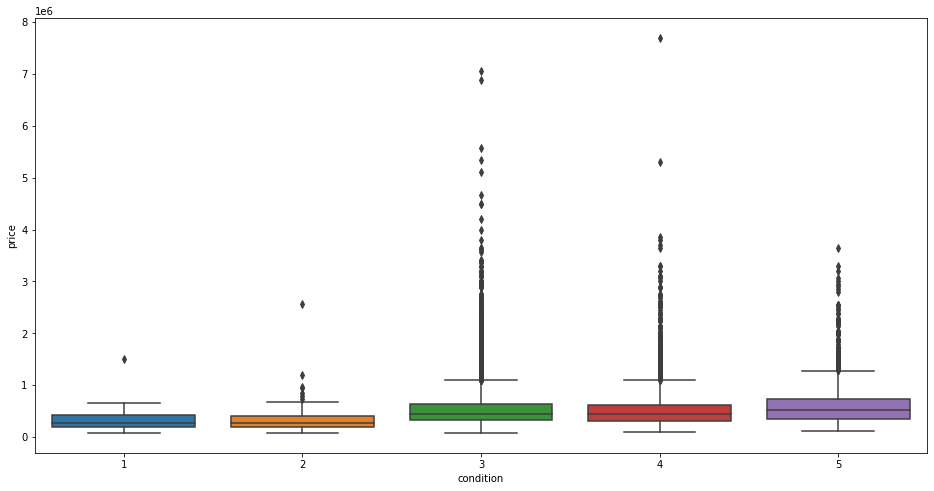

In [40]:
#box plot condition/saleprice
var = 'condition'
data = pd.concat([dep_var, hp_df[var]], axis=1)
fig, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="price", data=data)

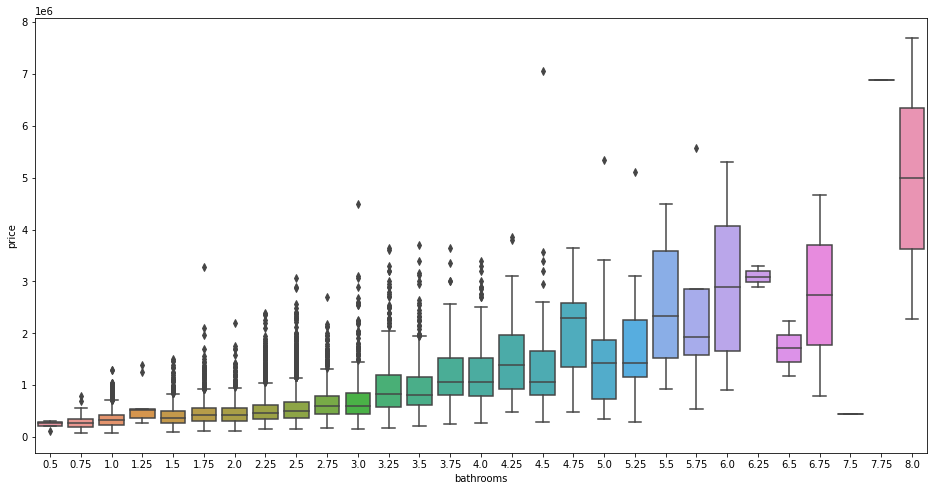

In [41]:
#box plot n bathrooms/saleprice
var = 'bathrooms'
data = pd.concat([dep_var, hp_df[var]], axis=1)
fig, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="price", data=data)

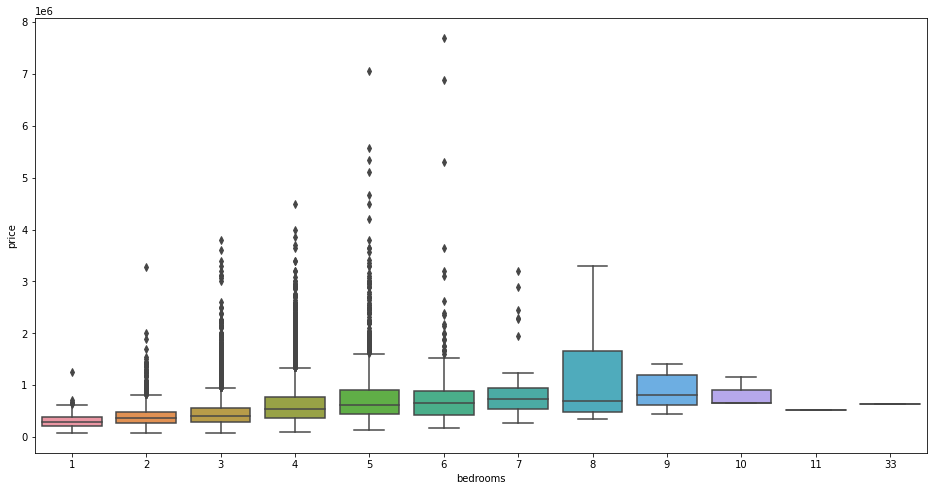

In [42]:
#box plot n bedrooms/saleprice
var = 'bedrooms'
data = pd.concat([dep_var, hp_df[var]], axis=1)
fig, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="price", data=data)

In [43]:
# Records with yr_renovated = 0

yr_renovated_n_0 = hp_df.yr_renovated.value_counts(dropna=False).sort_index()

print(f'The number of record with availabe info regarding the renovation year is {hp_df_shape[0] - yr_renovated_n_0[0]}.')


The number of record with availabe info regarding the renovation year is 914.


# Dropping Features

In [44]:
drop_columns = ["id", "date","sqft_lot", "sqft_above", "sqft_basement", "sqft_lot15", "condition"]

# id and date are useless for our analysis
# sqft_lot, sqft_above, sqft_basement and sqft_lot15 are highly correlated with sqft_living and therefore redundant
# the information contained in condition is already in grade and its correlation with price is very low. It can be dropped

In [45]:
hp_df = hp_df.drop(columns = drop_columns)

# Data Transformations

## Building Age treatment

### Transform yr_built into age

In [46]:
max(hp_df["yr_built"])

2015

In [47]:
yr_built_df = hp_df["yr_built"].copy()

In [48]:
hp_df["yr_built"] =  max(hp_df["yr_built"]) - hp_df["yr_built"]

In [49]:
hp_df = hp_df.rename(columns={"yr_built":"age"})

In [50]:
hp_df

,bedrooms,bathrooms,sqft_living,floors,waterfront,view,grade,age,yr_renovated,zipcode,lat,long,sqft_living15,price
0,3,1.00,1180,1.0,0,0,7,60,0,98178,47.5112,-122.257,1340,221900
1,3,2.25,2570,2.0,0,0,7,64,1991,98125,47.7210,-122.319,1690,538000
2,2,1.00,770,1.0,0,0,6,82,0,98028,47.7379,-122.233,2720,180000
3,4,3.00,1960,1.0,0,0,7,50,0,98136,47.5208,-122.393,1360,604000
4,3,2.00,1680,1.0,0,0,8,28,0,98074,47.6168,-122.045,1800,510000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,3,2.50,1530,3.0,0,0,8,6,0,98103,47.6993,-122.346,1530,360000
21593,4,2.50,2310,2.0,0,0,8,1,0,98146,47.5107,-122.362,1830,400000
21594,2,0.75,1020,2.0,0,0,7,6,0,98144,47.5944,-122.299,1020,402101
21595,3,2.50,1600,2.0,0,0,8,11,0,98027,47.5345,-122.069,1410,400000


### Transform yr_renovated into Binary

In [51]:
yr_renovated_df = hp_df["yr_renovated"].copy()

In [52]:
hp_df["yr_renovated"] = hp_df["yr_renovated"].where(hp_df["yr_renovated"]==0, other=1)

In [53]:
hp_df["yr_renovated"].value_counts()

0    20683
1      914
Name: yr_renovated, dtype: int64

In [54]:
hp_df = hp_df.rename(columns={"yr_renovated":"renovated"})

### Combine yr_built and yr_renovated into one single feature

What about if we combine the renovation year (with many zeros, possibly missing values) and the construction year into one single column. We will replace the construction year by the renovation year, for those record whit information regarding the renovation. 

In [55]:
yr_ren_built_df = yr_renovated_df.where(yr_renovated_df != 0, other = yr_built_df)
yr_ren_built_df

0        1955
1        1991
2        1933
3        1965
4        1987
         ... 
21592    2009
21593    2014
21594    2009
21595    2004
21596    2008
Name: yr_renovated, Length: 21597, dtype: int64

Let us now convert this new feature into a variable representing the age.

In [56]:
max(yr_ren_built_df)

2015

In [57]:
age_df =  max(yr_ren_built_df) - yr_ren_built_df
age_df

0        60
1        24
2        82
3        50
4        28
         ..
21592     6
21593     1
21594     6
21595    11
21596     7
Name: yr_renovated, Length: 21597, dtype: int64

In [58]:
hp_df["age"] = age_df
hp_df = hp_df.drop(columns=["renovated"])

In [59]:
hp_df

,bedrooms,bathrooms,sqft_living,floors,waterfront,view,grade,age,zipcode,lat,long,sqft_living15,price
0,3,1.00,1180,1.0,0,0,7,60,98178,47.5112,-122.257,1340,221900
1,3,2.25,2570,2.0,0,0,7,24,98125,47.7210,-122.319,1690,538000
2,2,1.00,770,1.0,0,0,6,82,98028,47.7379,-122.233,2720,180000
3,4,3.00,1960,1.0,0,0,7,50,98136,47.5208,-122.393,1360,604000
4,3,2.00,1680,1.0,0,0,8,28,98074,47.6168,-122.045,1800,510000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,3,2.50,1530,3.0,0,0,8,6,98103,47.6993,-122.346,1530,360000
21593,4,2.50,2310,2.0,0,0,8,1,98146,47.5107,-122.362,1830,400000
21594,2,0.75,1020,2.0,0,0,7,6,98144,47.5944,-122.299,1020,402101
21595,3,2.50,1600,2.0,0,0,8,11,98027,47.5345,-122.069,1410,400000


## Dropping row with 33 bedrooms

There is one record with 33 rooms that is obviously a typo. We will remove this row.

In [60]:
hp_df = hp_df[hp_df["bedrooms"] != 33]

In [61]:
hp_df

,bedrooms,bathrooms,sqft_living,floors,waterfront,view,grade,age,zipcode,lat,long,sqft_living15,price
0,3,1.00,1180,1.0,0,0,7,60,98178,47.5112,-122.257,1340,221900
1,3,2.25,2570,2.0,0,0,7,24,98125,47.7210,-122.319,1690,538000
2,2,1.00,770,1.0,0,0,6,82,98028,47.7379,-122.233,2720,180000
3,4,3.00,1960,1.0,0,0,7,50,98136,47.5208,-122.393,1360,604000
4,3,2.00,1680,1.0,0,0,8,28,98074,47.6168,-122.045,1800,510000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,3,2.50,1530,3.0,0,0,8,6,98103,47.6993,-122.346,1530,360000
21593,4,2.50,2310,2.0,0,0,8,1,98146,47.5107,-122.362,1830,400000
21594,2,0.75,1020,2.0,0,0,7,6,98144,47.5944,-122.299,1020,402101
21595,3,2.50,1600,2.0,0,0,8,11,98027,47.5345,-122.069,1410,400000


## Location Variables - dist_to_

C:\Users\ehern\miniconda3\envs\DA_Environment\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ehern\miniconda3\envs\DA_Environment\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\ehern\miniconda3\envs\DA_Environment\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexi

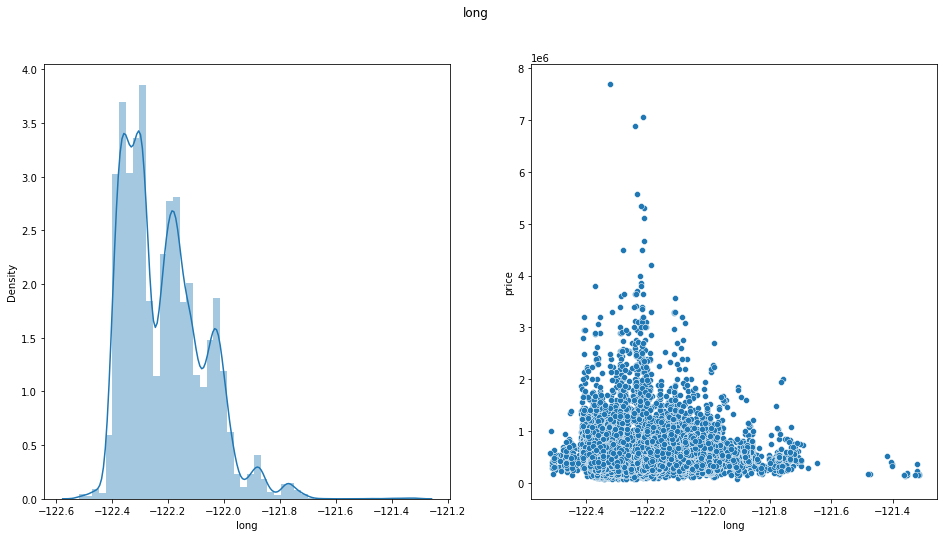

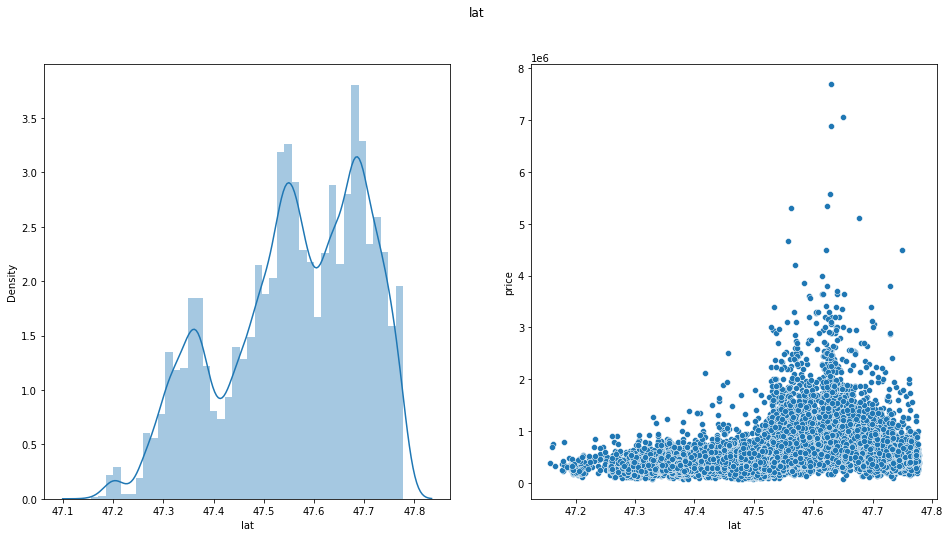

In [62]:
latlong = hp_df[['long', 'lat']]



for col in latlong:
    x = latlong[col]
    y = dep_var

    plt.figure(figsize=(16,8))
    plt.subplot(1,2,1)
    sns.distplot(x)
    plt.subplot(1,2,2)

    sns.scatterplot(x, y)
    plt.suptitle(col)
    #plt.tight_layout
    #plt.savefig(col + '.png')

In [63]:
latlong["long_lat"] = list(zip(latlong['long'], latlong['lat']))

C:\Users\ehern\AppData\Local\Temp/ipykernel_18644/1817949222.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  latlong["long_lat"] = list(zip(latlong['long'], latlong['lat']))


In [64]:
latlong["long_lat"]

0        (-122.257, 47.5112)
1         (-122.319, 47.721)
2        (-122.233, 47.7379)
3        (-122.393, 47.5208)
4        (-122.045, 47.6168)
                ...         
21592    (-122.346, 47.6993)
21593    (-122.362, 47.5107)
21594    (-122.299, 47.5944)
21595    (-122.069, 47.5345)
21596    (-122.299, 47.5941)
Name: long_lat, Length: 21596, dtype: object

In [65]:

hp_df['dist_to_seattle'] = latlong['long_lat'].apply(haversine)

hp_df['dist_to_bellevue'] = latlong['long_lat'].apply(haversine, other=[-122.188985, 47.616492])

# hp_df['dist_to_medina'] = latlong['long_lat'].apply(haversine, other=[-122.188985, 47.616492])

C:\Users\ehern\AppData\Local\Temp/ipykernel_18644/1277605618.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hp_df['dist_to_seattle'] = latlong['long_lat'].apply(haversine)
C:\Users\ehern\AppData\Local\Temp/ipykernel_18644/1277605618.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hp_df['dist_to_bellevue'] = latlong['long_lat'].apply(haversine, other=[-122.188985, 47.616492])


In [66]:
hp_df

,bedrooms,bathrooms,sqft_living,floors,waterfront,view,grade,age,zipcode,lat,long,sqft_living15,price,dist_to_seattle,dist_to_bellevue
0,3,1.00,1180,1.0,0,0,7,60,98178,47.5112,-122.257,1340,221900,12.434278,12.771789
1,3,2.25,2570,2.0,0,0,7,24,98125,47.7210,-122.319,1690,538000,12.477217,15.159928
2,2,1.00,770,1.0,0,0,6,82,98028,47.7379,-122.233,2720,180000,16.247460,13.896328
3,4,3.00,1960,1.0,0,0,7,50,98136,47.5208,-122.393,1360,604000,10.731122,18.641163
4,3,2.00,1680,1.0,0,0,8,28,98074,47.6168,-122.045,1800,510000,21.850148,10.792469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,3,2.50,1530,3.0,0,0,8,6,98103,47.6993,-122.346,1530,360000,10.023438,14.935753
21593,4,2.50,2310,2.0,0,0,8,1,98146,47.5107,-122.362,1830,400000,11.142749,17.518567
21594,2,0.75,1020,2.0,0,0,7,6,98144,47.5944,-122.299,1020,402101,3.254850,8.606001
21595,3,2.50,1600,2.0,0,0,8,11,98027,47.5345,-122.069,1410,400000,21.711999,12.811384


In [67]:
dep_var = hp_df["price"]
hp_df = hp_df.drop(columns="price")
hp_df["price"] = dep_var    

In [68]:
# hp_df = hp_df.drop(columns = ["zipcode", "lat", "long"])

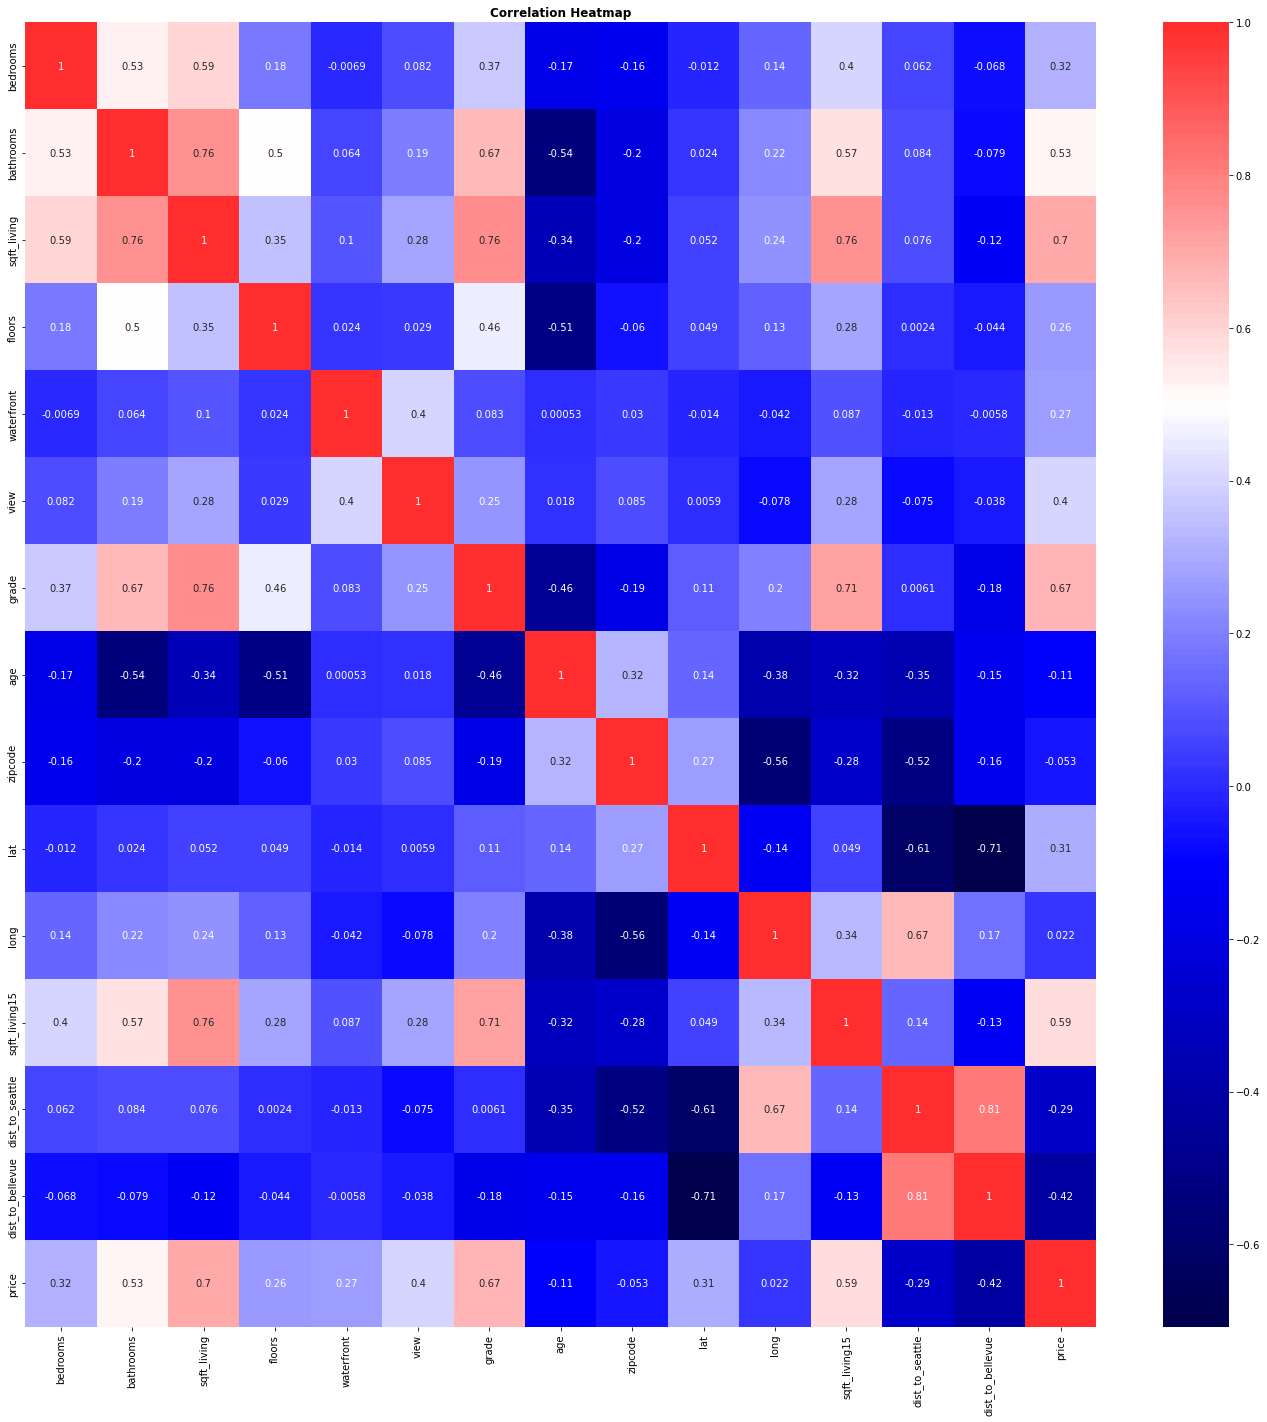

In [69]:
my_correlation_heatmap(hp_df, figsize=(24,24))

## Normalization - Price

## Price

C:\Users\ehern\miniconda3\envs\DA_Environment\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


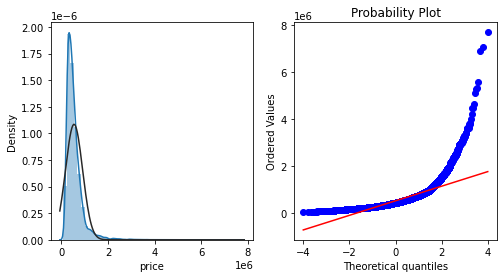

In [70]:
# create figure and axes
fig, axs = plt.subplots(1,2,figsize = (8,4))

sns.distplot(dep_var,fit=norm, ax=axs[0])
result = probplot(dep_var, plot=plt)

### Logarithmic Transformation

In [71]:
price_log_norm = np.log(dep_var)

C:\Users\ehern\miniconda3\envs\DA_Environment\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


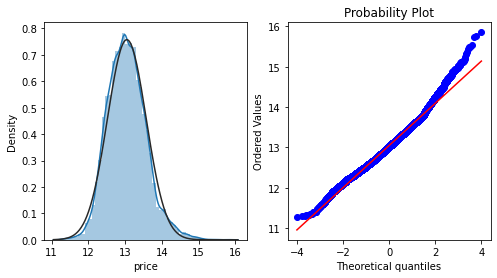

In [72]:
# create figure and axes
fig, axs = plt.subplots(1,2,figsize = (8,4))

sns.distplot(price_log_norm,fit=norm, ax=axs[0])
result = probplot(price_log_norm, plot=plt)

### Power Transformation

In [73]:
price_transformer = PowerTransformer(method="box-cox").fit(dep_var.to_numpy().reshape(-1,1))

price_power_norm = price_transformer.transform(dep_var.to_numpy().reshape(-1,1))
print(price_transformer.lambdas_)
price_power_norm = pd.DataFrame(price_power_norm)[0]

[-0.23615535]


C:\Users\ehern\miniconda3\envs\DA_Environment\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


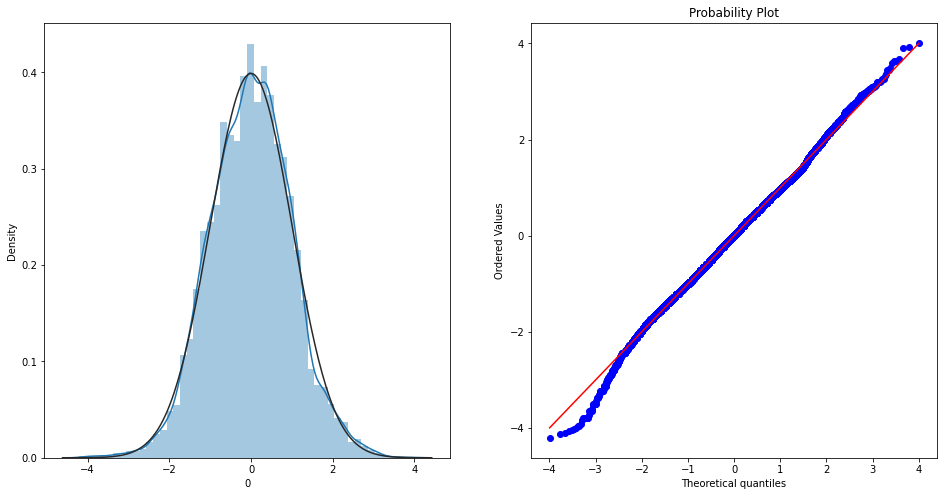

In [74]:
# create figure and axes
fig, axs = plt.subplots(1,2,figsize = (16,8))

sns.distplot(price_power_norm,fit=norm, ax=axs[0])
result = probplot(price_power_norm, plot=plt)

## Normalization - sqft_living

C:\Users\ehern\miniconda3\envs\DA_Environment\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


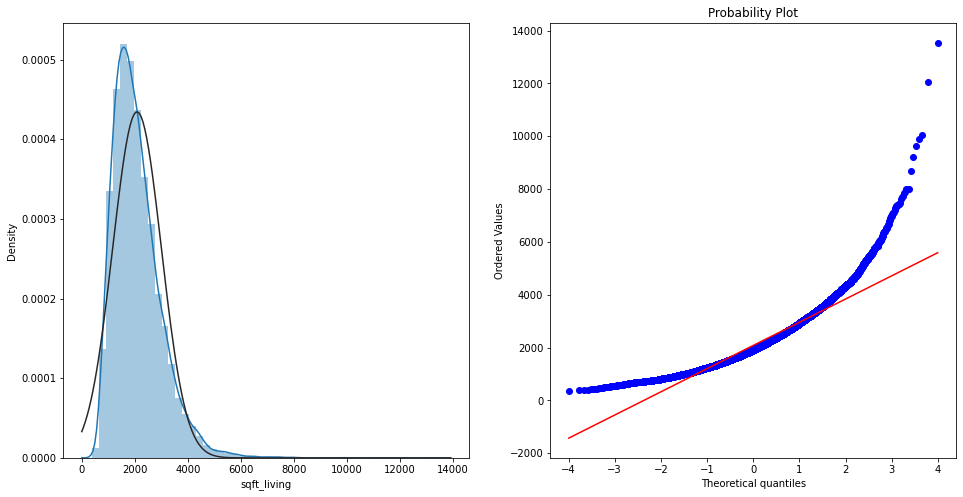

In [75]:
var = "sqft_living"

# create figure and axes
fig, axs = plt.subplots(1,2,figsize = (16,8))

sns.distplot(hp_df[var],fit=norm, ax=axs[0])
result = probplot(hp_df[var], plot=plt)

### Logarithmic Transformation

In [76]:
sqft_living_log_norm = np.log(hp_df[var])

C:\Users\ehern\miniconda3\envs\DA_Environment\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


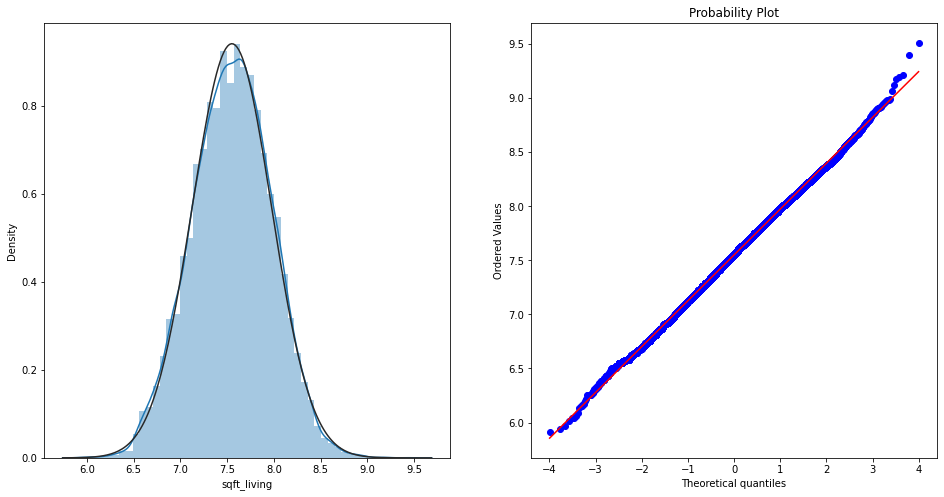

In [77]:
# create figure and axes
fig, axs = plt.subplots(1,2,figsize = (16,8))

sns.distplot(sqft_living_log_norm,fit=norm, ax=axs[0])
result = probplot(sqft_living_log_norm, plot=plt)

### Power Transformation

In [78]:
sqft_living_transformer = PowerTransformer(method="box-cox").fit(hp_df[var].to_numpy().reshape(-1,1))

sqft_living_power_norm = sqft_living_transformer.transform(hp_df[var].to_numpy().reshape(-1,1))
print(sqft_living_transformer.lambdas_)
sqft_living_power_norm = pd.DataFrame(sqft_living_power_norm)[0]

[0.02221622]


C:\Users\ehern\miniconda3\envs\DA_Environment\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


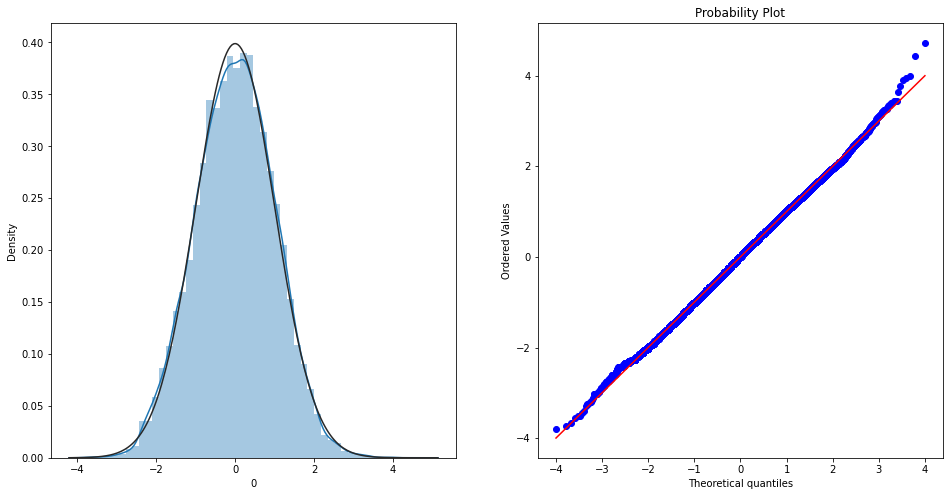

In [79]:
# create figure and axes
fig, axs = plt.subplots(1,2,figsize = (16,8))

sns.distplot(sqft_living_power_norm,fit=norm, ax=axs[0])
result = probplot(sqft_living_power_norm, plot=plt)

## Normalization - sqft_living15

C:\Users\ehern\miniconda3\envs\DA_Environment\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


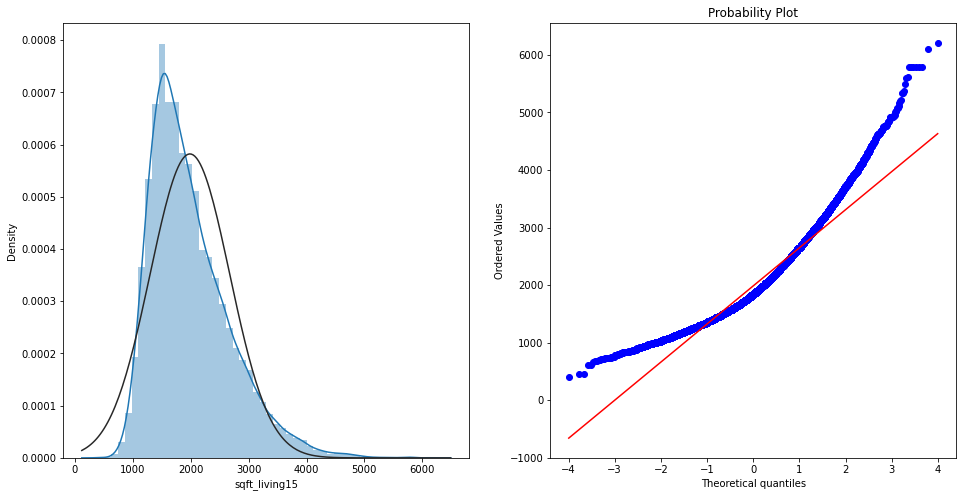

In [80]:
var = "sqft_living15"

# create figure and axes
fig, axs = plt.subplots(1,2,figsize = (16,8))

sns.distplot(hp_df[var],fit=norm, ax=axs[0])
result = probplot(hp_df[var], plot=plt)

### Logarithmic Transformation

In [81]:
sqft_living15_log_norm = np.log(hp_df[var])

C:\Users\ehern\miniconda3\envs\DA_Environment\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


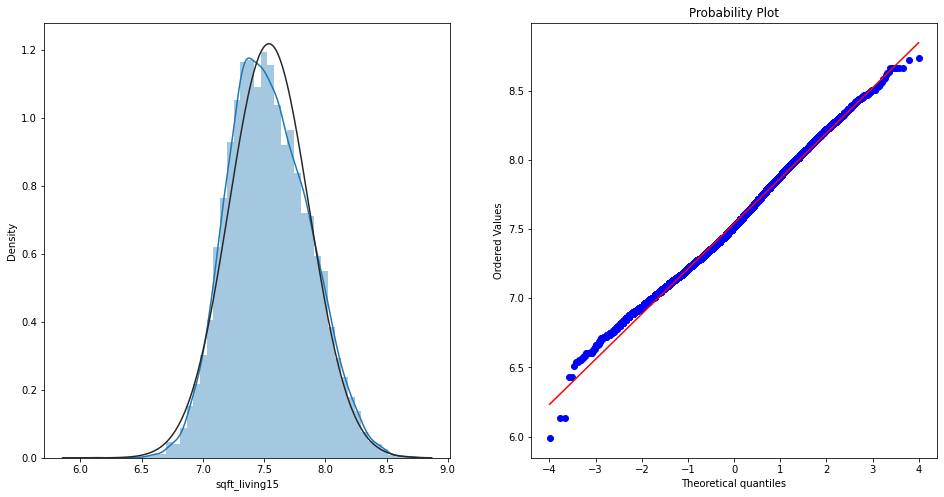

In [82]:
# create figure and axes
fig, axs = plt.subplots(1,2,figsize = (16,8))

sns.distplot(sqft_living15_log_norm,fit=norm, ax=axs[0])
result = probplot(sqft_living15_log_norm, plot=plt)

### Power Transformation

In [83]:
sqft_living15_transformer = PowerTransformer(method="box-cox").fit(hp_df[var].to_numpy().reshape(-1,1))

sqft_living15_power_norm = sqft_living15_transformer.transform(hp_df[var].to_numpy().reshape(-1,1))
print(sqft_living15_transformer.lambdas_)
sqft_living15_power_norm = pd.DataFrame(sqft_living15_power_norm)[0]

[-0.23134014]


C:\Users\ehern\miniconda3\envs\DA_Environment\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


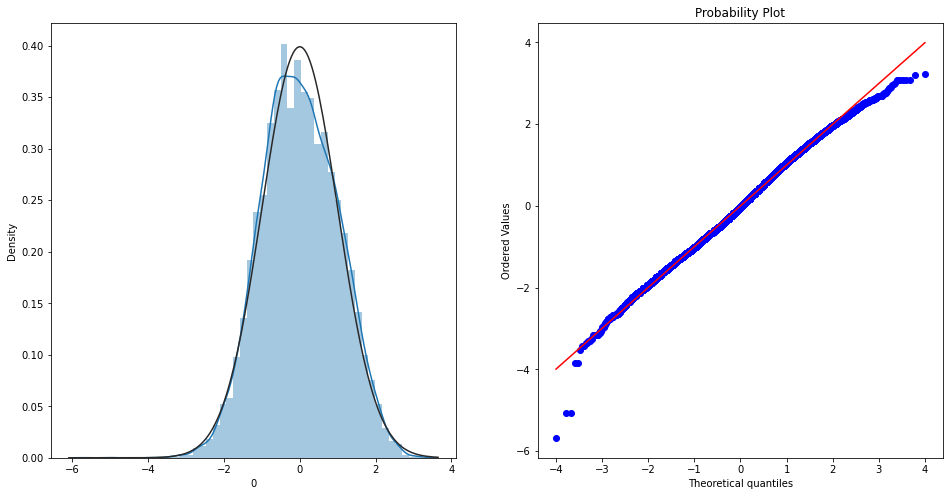

In [84]:
# create figure and axes
fig, axs = plt.subplots(1,2,figsize = (16,8))

sns.distplot(sqft_living15_power_norm,fit=norm, ax=axs[0])
result = probplot(sqft_living15_power_norm, plot=plt)

In [85]:
hp_df["price"] = price_power_norm
hp_df["sqft_living"] = sqft_living_log_norm
hp_df["sqft_living15"] = sqft_living15_log_norm

In [86]:
hp_df

,bedrooms,bathrooms,sqft_living,floors,waterfront,view,grade,age,zipcode,lat,long,sqft_living15,dist_to_seattle,dist_to_bellevue,price
0,3,1.00,7.073270,1.0,0,0,7,60,98178,47.5112,-122.257,7.200425,12.434278,12.771789,-1.489816
1,3,2.25,7.851661,2.0,0,0,7,24,98125,47.7210,-122.319,7.432484,12.477217,15.159928,0.340977
2,2,1.00,6.646391,1.0,0,0,6,82,98028,47.7379,-122.233,7.908387,16.247460,13.896328,-1.981281
3,4,3.00,7.580700,1.0,0,0,7,50,98136,47.5208,-122.393,7.215240,10.731122,18.641163,0.553130
4,3,2.00,7.426549,1.0,0,0,8,28,98074,47.6168,-122.045,7.495542,21.850148,10.792469,0.241010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,3,2.50,7.333023,3.0,0,0,8,6,98103,47.6993,-122.346,7.333023,10.023438,14.935753,-0.229629
21593,4,2.50,7.745003,2.0,0,0,8,1,98146,47.5107,-122.362,7.512071,11.142749,17.518567,-0.219193
21594,2,0.75,6.927558,2.0,0,0,7,6,98144,47.5944,-122.299,6.927558,3.254850,8.606001,-0.229629
21595,3,2.50,7.377759,2.0,0,0,8,11,98027,47.5345,-122.069,7.251345,21.711999,12.811384,-0.653837


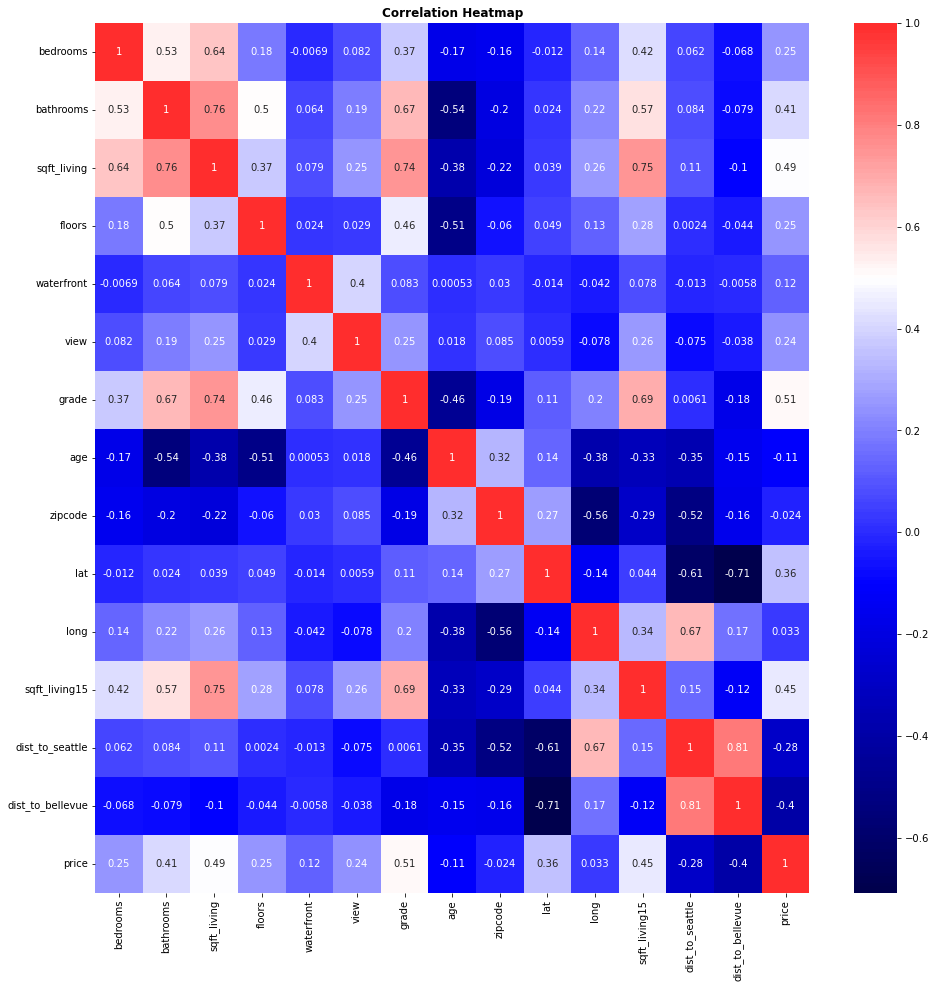

In [87]:
my_correlation_heatmap(hp_df)

## Conversion to Category Type

In [88]:
cat_columns = ['waterfront', 'view', 'grade', 'renovated']

In [89]:
# hp_df = obj_to_cat(hp_df, columns_list=cat_columns)

# Regression Models

## Model 1 - Simple Linear Regression (sqft_living VS Price)

In [90]:
# Import the data and define our dataframe

hp_df = (load_data("Data_MidTerm_Project_Real_State_Regression.xls")
.pipe(standard_headings)
[["sqft_living", "price"]]
.reset_index(drop = True)
)


In [91]:
# Normalization

# hp_df["price"] = var_normalization(hp_df["price"])[1]
# hp_df["sqft_living"] = var_normalization(hp_df["sqft_living"])[1]

In [92]:
split_scaling_encoding_output = my_transformations(hp_df, test_size=0.2, scaler=None)

In [93]:
X_train = split_scaling_encoding_output["train"][0]
y_train = split_scaling_encoding_output["train"][2].reset_index(drop=True)

X_test = split_scaling_encoding_output["test"][0]
y_test = split_scaling_encoding_output["test"][2].reset_index(drop=True)

In [94]:
X_train

,sqft_living
0,3786
1,860
2,1470
3,1640
4,2840
...,...
17272,1250
17273,1830
17274,1460
17275,1120


In [95]:
y_train

0        1380000
1          82000
2         220000
3         369950
4         870000
          ...   
17272     468000
17273     275000
17274     629000
17275     442500
17276     700000
Name: price, Length: 17277, dtype: int64

The model performance for the train set
-------------------------------------------
RMSE of train set is 264538.24713086965
Adjusted R2 score of train set is 0.4974119642199867

The model performance for the test set
-------------------------------------------
RMSE of test set is 249948.33791722127
Adjusted R2 score of test set is 0.46916431082075616


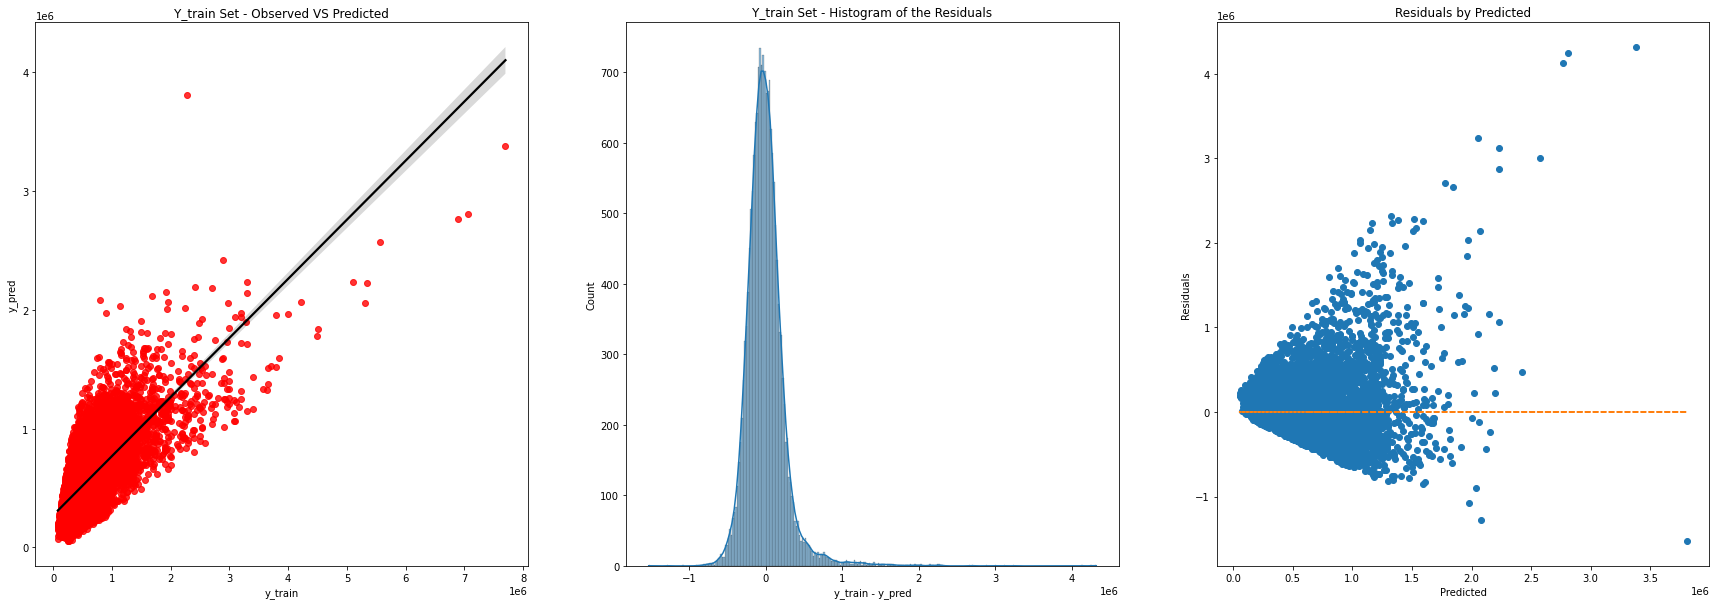

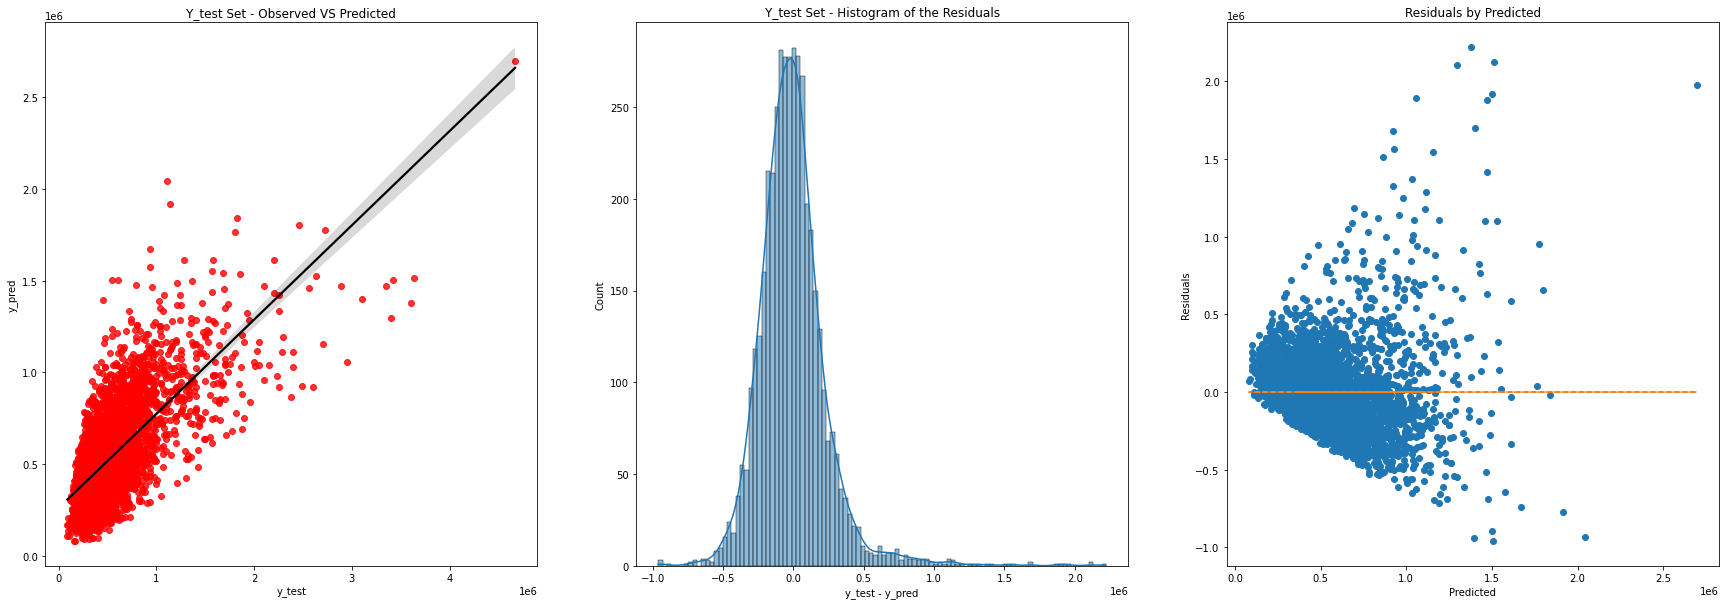

In [96]:
reg_m1_output = my_linear_regression(X_train, y_train, X_test, y_test)

## Model 2 - Multiple Linear Regression (all variables) - with statsmodels

In [387]:
# Inputs for the Pipeline Controller

drop_columns = ["id", "date"]
cat_columns = ['waterfront', 'view', 'grade', "zipcode", "condition"]

In [388]:
# Pipeline Control

hp_df = (load_data("Data_MidTerm_Project_Real_State_Regression.xls")
.pipe(standard_headings)
.drop(drop_columns, axis=1)
# .pipe(transform_age)
# .pipe(transform_renovated)
.pipe(obj_to_cat, cat_columns)
.pipe(remove_rows)
.reset_index(drop=True)
)

In [389]:
# Logarithmic / Box- Plot Normalization

# hp_df["price"] = np.log(hp_df["price"])
# hp_df["sqft_living"] = var_normalization(hp_df["sqft_living"])[1]
# hp_df["sqft_living15"] = var_normalization(hp_df["sqft_living15"])[1]

In [390]:
# Location to Distance_to Transformation

# latlong = hp_df[['long', 'lat']]
# latlong["long_lat"] = list(zip(latlong['long'], latlong['lat']))
# hp_df.insert(hp_df.shape[1]-1, 'dist_to_seattle', latlong['long_lat'].apply(haversine))
# hp_df.insert(hp_df.shape[1]-1, 'dist_to_bellevue', latlong['long_lat'].apply(haversine, other=[-122.188985, 47.616492]))
# # hp_df = hp_df.drop(["zipcode", "long", "lat"], axis=1)


In [391]:
split_scaling_encoding_output = my_transformations(hp_df, test_size=0.2, scaler=None)

In [392]:
X_train = pd.concat([split_scaling_encoding_output["train"][0], split_scaling_encoding_output["train"][1].reset_index(drop=True)], axis=1)
y_train = split_scaling_encoding_output["train"][2].reset_index(drop=True)

X_test = pd.concat([split_scaling_encoding_output["test"][0], split_scaling_encoding_output["test"][1].reset_index(drop=True)], axis=1)
y_test = split_scaling_encoding_output["test"][2].reset_index(drop=True)

In [370]:
X_train

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,waterfront,view,condition,grade,zipcode
0,4,2.50,2760,5564,2.0,2760,0,2001,0,47.4814,-122.189,2670,5626,0,0,3,7,98056
1,3,2.75,2940,12487,2.0,2940,0,1997,0,47.5879,-121.973,3110,10837,0,0,3,10,98075
2,3,2.25,1445,1606,2.0,1300,145,2003,0,47.5348,-122.072,1410,1286,0,0,3,7,98027
3,3,1.75,1810,41800,1.0,1210,600,1980,0,47.4109,-121.958,1650,135036,0,0,5,7,98038
4,2,2.50,1680,977,3.0,1680,0,2009,0,47.6320,-122.361,1680,977,0,0,3,9,98119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17271,2,1.75,1250,7029,1.0,1250,0,1986,0,47.6936,-122.186,1680,8470,0,0,4,7,98033
17272,3,2.25,998,844,2.0,798,200,2007,0,47.6983,-122.367,998,1110,0,0,3,7,98117
17273,3,1.75,1460,12367,2.0,1120,340,1970,0,47.3311,-122.375,1970,18893,1,4,4,8,98023
17274,3,1.00,1120,8200,1.0,1120,0,1938,0,47.7254,-122.290,1820,7205,0,0,4,7,98125


In [393]:
y_train

0        424950
1        795000
2        387000
3        314000
4        935000
          ...  
17271    468000
17272    320000
17273    629000
17274    442500
17275    700000
Name: price, Length: 17276, dtype: int64

In [394]:
# Summary from statsmodels

X_train_const = sm.add_constant(X_train)  
X_test_const = sm.add_constant(X_test)

model = sm.OLS(y_train, X_train_const).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.698
Model:                            OLS   Adj. R-squared:                  0.697
Method:                 Least Squares   F-statistic:                     2344.
Date:                Thu, 18 Nov 2021   Prob (F-statistic):               0.00
Time:                        20:30:14   Log-Likelihood:            -2.3576e+05
No. Observations:               17276   AIC:                         4.716e+05
Df Residuals:                   17258   BIC:                         4.717e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          7.047e+06   3.34e+06      2.109

The model performance for the train set
-------------------------------------------
RMSE of train set is 204389.4654182188
Adjusted R2 score of train set is 0.6974477229539168

The model performance for the test set
-------------------------------------------
RMSE of test set is 187189.3415701135
Adjusted R2 score of test set is 0.7111737092087795


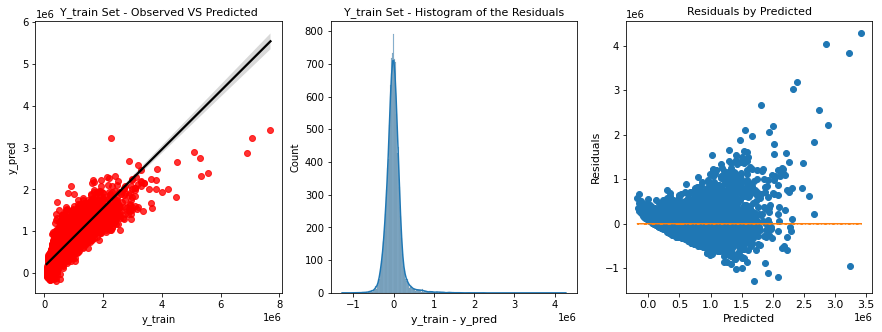

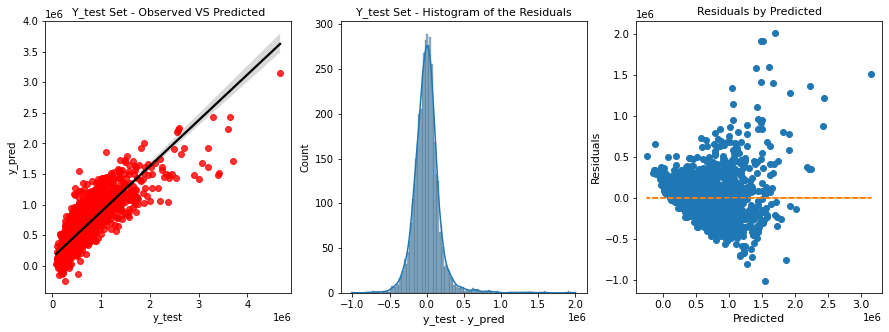

In [395]:
reg_m2_output = my_flex_regression(X_train, y_train, X_test, y_test, model=LinearRegression(), y_transformer=None)

## Model 3 - Multiple Linear Regression (reduced number of variables)

In [396]:
# Inputs for the Pipeline Controller

drop_columns = ["id", "date","sqft_lot", "sqft_above", "sqft_basement", "sqft_lot15", "condition", "floors", "sqft_living15"]
cat_columns = ['waterfront', 'view', 'grade', "zipcode"]

In [397]:
# Pipeline Control

hp_df = (load_data("Data_MidTerm_Project_Real_State_Regression.xls")
.pipe(standard_headings)
.drop(drop_columns, axis=1)
.pipe(transform_renovated_built)
# .pipe(transform_age)
# .pipe(transform_renovated)
.pipe(obj_to_cat, cat_columns)
.pipe(remove_rows)
.reset_index(drop=True)
)

In [398]:
# Logarithmic / Box- Plot Normalization

hp_df["price"] = np.log(hp_df["price"])
# hp_df["sqft_living"] = np.log(hp_df["sqft_living"])
# hp_df["sqft_living15"] = np.log(hp_df["sqft_living15"])

hp_df["sqft_living"] = var_normalization(hp_df["sqft_living"])[1]
# hp_df["sqft_living15"] = var_normalization(hp_df["sqft_living15"])[1]

In [399]:
# Location to Distance_to Transformation

latlong = hp_df[['long', 'lat']]
latlong["long_lat"] = list(zip(latlong['long'], latlong['lat']))
hp_df.insert(hp_df.shape[1]-1, 'dist_to_seattle', latlong['long_lat'].apply(haversine))
hp_df.insert(hp_df.shape[1]-1, 'dist_to_bellevue', latlong['long_lat'].apply(haversine, other=[-122.188985, 47.616492]))
# hp_df = hp_df.drop(["zipcode", "long", "lat"], axis=1)


C:\Users\ehern\AppData\Local\Temp/ipykernel_18644/1521038070.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  latlong["long_lat"] = list(zip(latlong['long'], latlong['lat']))


In [400]:
split_scaling_encoding_output = my_transformations(hp_df, test_size=0.2, scaler="standard")

In [401]:
X_train = pd.concat([split_scaling_encoding_output["train"][0], split_scaling_encoding_output["train"][1].reset_index(drop=True)], axis=1)
y_train = split_scaling_encoding_output["train"][2].reset_index(drop=True)

X_test = pd.concat([split_scaling_encoding_output["test"][0], split_scaling_encoding_output["test"][1].reset_index(drop=True)], axis=1)
y_test = split_scaling_encoding_output["test"][2].reset_index(drop=True)

In [402]:
X_train

,bedrooms,bathrooms,sqft_living,age,lat,long,dist_to_seattle,dist_to_bellevue,waterfront,view,grade,zipcode
0,0.692179,0.49184,0.870075,-0.953874,-0.573493,0.178190,-0.054263,-0.269736,0,0,7,98056
1,-0.414027,0.81582,1.020563,-0.815361,0.193592,1.708209,0.807322,-0.109376,0,0,10,98075
2,-0.414027,0.16786,-0.659226,-1.023130,-0.188870,1.006950,0.266439,-0.528615,0,0,7,98027
3,-0.414027,-0.48010,-0.129476,-0.226684,-1.081282,1.814460,1.605235,1.210829,0,0,7,98038
4,-1.520233,0.49184,-0.305084,-1.230898,0.511231,-1.040159,-1.431184,-0.487900,0,0,9,98119
...,...,...,...,...,...,...,...,...,...,...,...,...
17271,-1.520233,-0.48010,-0.998811,-0.434452,0.954916,0.199440,-0.366569,-0.967427,0,0,7,98033
17272,-0.414027,0.16786,-1.524054,-1.161642,0.988768,-1.082659,-0.781713,-0.148616,0,0,7,98117
17273,-0.414027,-0.48010,-0.634993,0.119597,-1.656056,-1.139327,1.152744,1.858193,1,4,8,98023
17274,-0.414027,-1.45204,-1.255327,1.227695,1.183961,-0.537236,-0.485359,-0.350227,0,0,7,98125


In [403]:
y_train

0        12.959727
1        13.586097
2        12.866180
3        12.657148
4        13.748302
           ...    
17271    13.056224
17272    12.676076
17273    13.351887
17274    13.000196
17275    13.458836
Name: price, Length: 17276, dtype: float64

In [404]:
# Summary from statsmodels

X_train_const = sm.add_constant(X_train)  
X_test_const = sm.add_constant(X_test)

model = sm.OLS(y_train, X_train_const).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     5613.
Date:                Thu, 18 Nov 2021   Prob (F-statistic):               0.00
Time:                        20:30:34   Log-Likelihood:                 289.97
No. Observations:               17276   AIC:                            -553.9
Df Residuals:                   17263   BIC:                            -453.1
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              146.1000      4.867  

The model performance for the train set
-------------------------------------------
RMSE of train set is 168307.6405280054
Adjusted R2 score of train set is 0.7949120696704672

The model performance for the test set
-------------------------------------------
RMSE of test set is 156396.83161145865
Adjusted R2 score of test set is 0.7986623656298695


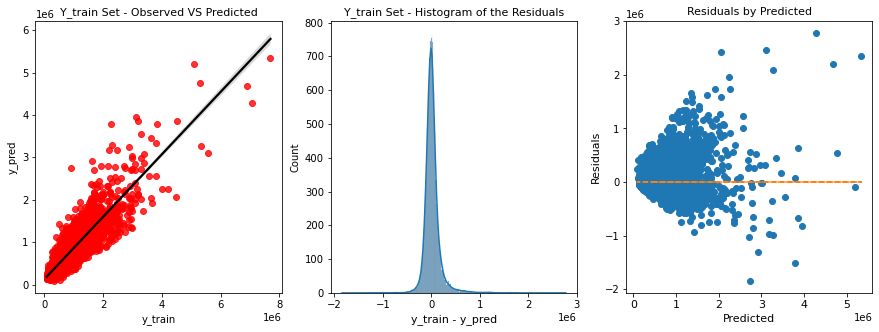

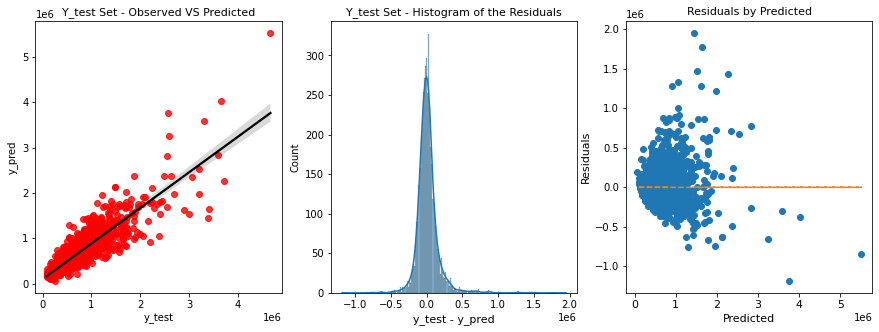

In [405]:
reg_m3_output = my_flex_regression(X_train, y_train, X_test, y_test, model=LinearRegression(), y_transformer = "log")

In [352]:
m = reg_m3_output["Model"]

In [353]:
list(zip(hp_df.columns, m.coef_))

[('bedrooms', -0.02626816201707401),
 ('bathrooms', 0.030724642688945248),
 ('sqft_living', 0.2077763891174283),
 ('waterfront', 0.06376374297226664),
 ('view', 0.10740576721506617),
 ('grade', 0.15085551290897922),
 ('age', -0.3524428843777797),
 ('zipcode', 0.11672806361049236),
 ('lat', 0.46870179054239547),
 ('long', 0.07794728844816066),
 ('dist_to_seattle', 0.15777162599463776),
 ('dist_to_bellevue', -0.0013691096913434966)]

## Model 4 - Ridge Regression

In [406]:
# Inputs for the Pipeline Controller

drop_columns = ["id", "date","sqft_lot", "sqft_above", "sqft_basement", "sqft_lot15", "condition", "floors", "sqft_living15"]
cat_columns = ['waterfront', 'view', 'grade', "zipcode"]

In [407]:
# Pipeline Control

hp_df = (load_data("Data_MidTerm_Project_Real_State_Regression.xls")
.pipe(standard_headings)
.drop(drop_columns, axis=1)
.pipe(transform_renovated_built)
# .pipe(transform_age)
# .pipe(transform_renovated)
.pipe(obj_to_cat, cat_columns)
.pipe(remove_rows)
.reset_index(drop=True)
)

In [408]:
# Logarithmic / Box- Plot Normalization

hp_df["price"] = np.log(hp_df["price"])
# hp_df["sqft_living"] = np.log(hp_df["sqft_living"])
# hp_df["sqft_living15"] = np.log(hp_df["sqft_living15"])

hp_df["sqft_living"] = var_normalization(hp_df["sqft_living"])[1]
# hp_df["sqft_living15"] = var_normalization(hp_df["sqft_living15"])[1]

In [409]:
# Location to Distance_to Transformation

latlong = hp_df[['long', 'lat']]
latlong["long_lat"] = list(zip(latlong['long'], latlong['lat']))
hp_df.insert(hp_df.shape[1]-1, 'dist_to_seattle', latlong['long_lat'].apply(haversine))
hp_df.insert(hp_df.shape[1]-1, 'dist_to_bellevue', latlong['long_lat'].apply(haversine, other=[-122.188985, 47.616492]))
# hp_df = hp_df.drop(["zipcode", "long", "lat"], axis=1)


C:\Users\ehern\AppData\Local\Temp/ipykernel_18644/1521038070.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  latlong["long_lat"] = list(zip(latlong['long'], latlong['lat']))


In [411]:
split_scaling_encoding_output = my_transformations(hp_df, test_size=0.2, scaler="standard")

In [412]:
X_train = pd.concat([split_scaling_encoding_output["train"][0], split_scaling_encoding_output["train"][1].reset_index(drop=True)], axis=1)
y_train = split_scaling_encoding_output["train"][2].reset_index(drop=True)

X_test = pd.concat([split_scaling_encoding_output["test"][0], split_scaling_encoding_output["test"][1].reset_index(drop=True)], axis=1)
y_test = split_scaling_encoding_output["test"][2].reset_index(drop=True)

In [413]:
X_train

,bedrooms,bathrooms,sqft_living,age,lat,long,dist_to_seattle,dist_to_bellevue,waterfront,view,grade,zipcode
0,0.692179,0.49184,0.870075,-0.953874,-0.573493,0.178190,-0.054263,-0.269736,0,0,7,98056
1,-0.414027,0.81582,1.020563,-0.815361,0.193592,1.708209,0.807322,-0.109376,0,0,10,98075
2,-0.414027,0.16786,-0.659226,-1.023130,-0.188870,1.006950,0.266439,-0.528615,0,0,7,98027
3,-0.414027,-0.48010,-0.129476,-0.226684,-1.081282,1.814460,1.605235,1.210829,0,0,7,98038
4,-1.520233,0.49184,-0.305084,-1.230898,0.511231,-1.040159,-1.431184,-0.487900,0,0,9,98119
...,...,...,...,...,...,...,...,...,...,...,...,...
17271,-1.520233,-0.48010,-0.998811,-0.434452,0.954916,0.199440,-0.366569,-0.967427,0,0,7,98033
17272,-0.414027,0.16786,-1.524054,-1.161642,0.988768,-1.082659,-0.781713,-0.148616,0,0,7,98117
17273,-0.414027,-0.48010,-0.634993,0.119597,-1.656056,-1.139327,1.152744,1.858193,1,4,8,98023
17274,-0.414027,-1.45204,-1.255327,1.227695,1.183961,-0.537236,-0.485359,-0.350227,0,0,7,98125


In [414]:
y_train

0        12.959727
1        13.586097
2        12.866180
3        12.657148
4        13.748302
           ...    
17271    13.056224
17272    12.676076
17273    13.351887
17274    13.000196
17275    13.458836
Name: price, Length: 17276, dtype: float64

The model performance for the train set
-------------------------------------------
RMSE of train set is 168316.0728155796
Adjusted R2 score of train set is 0.7948915191628139

The model performance for the test set
-------------------------------------------
RMSE of test set is 156348.33578747843
Adjusted R2 score of test set is 0.7987872085765113


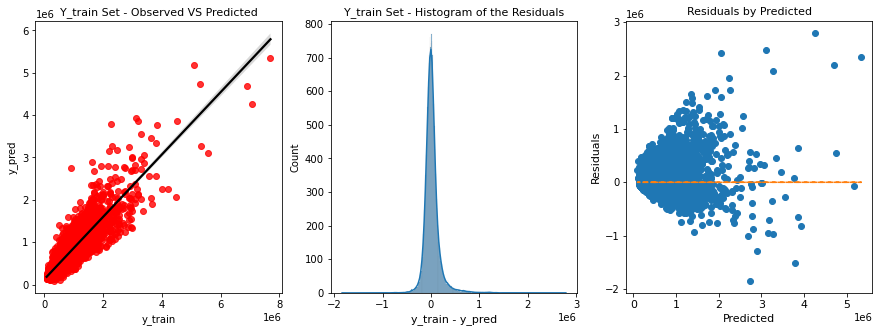

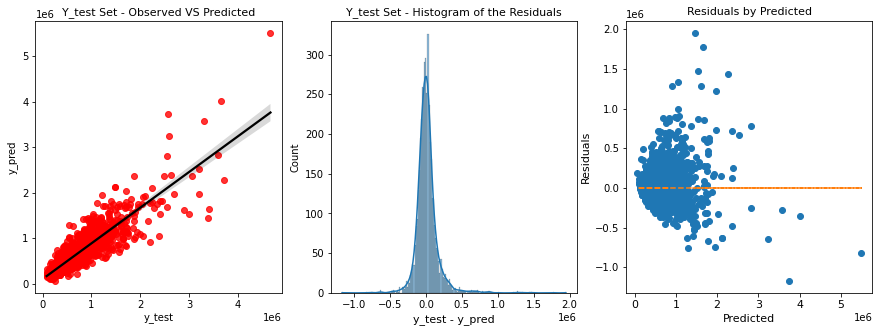

In [415]:
reg_m4_output = my_flex_regression(X_train, y_train, X_test, y_test, model = Ridge(), y_transformer = "log", alpha = 1)

## Model 5 - Lasso Regression

In [416]:
# Inputs for the Pipeline Controller

drop_columns = ["id", "date","sqft_lot", "sqft_above", "sqft_basement", "sqft_lot15", "condition", "floors", "sqft_living15"]
cat_columns = ['waterfront', 'view', 'grade', "zipcode"]

In [417]:
# Pipeline Control

hp_df = (load_data("Data_MidTerm_Project_Real_State_Regression.xls")
.pipe(standard_headings)
.drop(drop_columns, axis=1)
.pipe(transform_renovated_built)
# .pipe(transform_age)
# .pipe(transform_renovated)
.pipe(obj_to_cat, cat_columns)
.pipe(remove_rows)
.reset_index(drop=True)
)

In [418]:
# Logarithmic / Box- Plot Normalization

hp_df["price"] = np.log(hp_df["price"])
# hp_df["sqft_living"] = np.log(hp_df["sqft_living"])
# hp_df["sqft_living15"] = np.log(hp_df["sqft_living15"])

hp_df["sqft_living"] = var_normalization(hp_df["sqft_living"])[1]
# hp_df["sqft_living15"] = var_normalization(hp_df["sqft_living15"])[1]

In [419]:
# Location to Distance_to Transformation

latlong = hp_df[['long', 'lat']]
latlong["long_lat"] = list(zip(latlong['long'], latlong['lat']))
hp_df.insert(hp_df.shape[1]-1, 'dist_to_seattle', latlong['long_lat'].apply(haversine))
hp_df.insert(hp_df.shape[1]-1, 'dist_to_bellevue', latlong['long_lat'].apply(haversine, other=[-122.188985, 47.616492]))
# hp_df = hp_df.drop(["zipcode", "long", "lat"], axis=1)


C:\Users\ehern\AppData\Local\Temp/ipykernel_18644/1521038070.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  latlong["long_lat"] = list(zip(latlong['long'], latlong['lat']))


In [420]:
split_scaling_encoding_output = my_transformations(hp_df, test_size=0.2, scaler="standard")

In [421]:
X_train = pd.concat([split_scaling_encoding_output["train"][0], split_scaling_encoding_output["train"][1].reset_index(drop=True)], axis=1)
y_train = split_scaling_encoding_output["train"][2].reset_index(drop=True)

X_test = pd.concat([split_scaling_encoding_output["test"][0], split_scaling_encoding_output["test"][1].reset_index(drop=True)], axis=1)
y_test = split_scaling_encoding_output["test"][2].reset_index(drop=True)

In [422]:
X_train

,bedrooms,bathrooms,sqft_living,age,lat,long,dist_to_seattle,dist_to_bellevue,waterfront,view,grade,zipcode
0,0.692179,0.49184,0.870075,-0.953874,-0.573493,0.178190,-0.054263,-0.269736,0,0,7,98056
1,-0.414027,0.81582,1.020563,-0.815361,0.193592,1.708209,0.807322,-0.109376,0,0,10,98075
2,-0.414027,0.16786,-0.659226,-1.023130,-0.188870,1.006950,0.266439,-0.528615,0,0,7,98027
3,-0.414027,-0.48010,-0.129476,-0.226684,-1.081282,1.814460,1.605235,1.210829,0,0,7,98038
4,-1.520233,0.49184,-0.305084,-1.230898,0.511231,-1.040159,-1.431184,-0.487900,0,0,9,98119
...,...,...,...,...,...,...,...,...,...,...,...,...
17271,-1.520233,-0.48010,-0.998811,-0.434452,0.954916,0.199440,-0.366569,-0.967427,0,0,7,98033
17272,-0.414027,0.16786,-1.524054,-1.161642,0.988768,-1.082659,-0.781713,-0.148616,0,0,7,98117
17273,-0.414027,-0.48010,-0.634993,0.119597,-1.656056,-1.139327,1.152744,1.858193,1,4,8,98023
17274,-0.414027,-1.45204,-1.255327,1.227695,1.183961,-0.537236,-0.485359,-0.350227,0,0,7,98125


In [423]:
y_train

0        12.959727
1        13.586097
2        12.866180
3        12.657148
4        13.748302
           ...    
17271    13.056224
17272    12.676076
17273    13.351887
17274    13.000196
17275    13.458836
Name: price, Length: 17276, dtype: float64

The model performance for the train set
-------------------------------------------
RMSE of train set is 255194.60609074304
Adjusted R2 score of train set is 0.5285068144676932

The model performance for the test set
-------------------------------------------
RMSE of test set is 233025.04376373085
Adjusted R2 score of test set is 0.5530342382787747


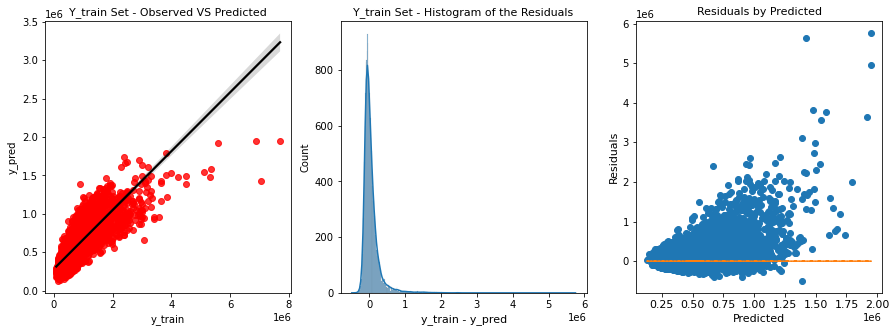

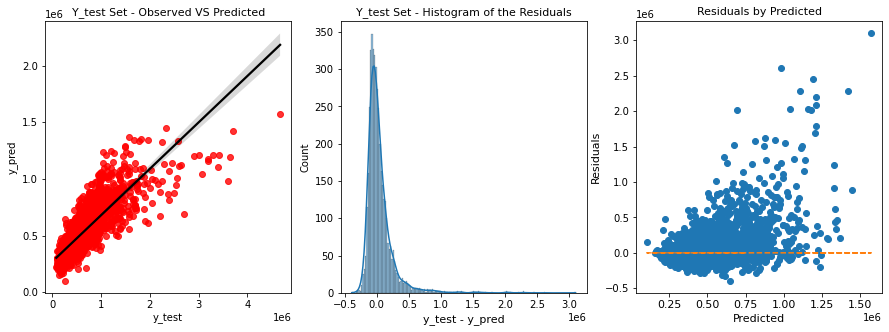

In [424]:
reg_m4_output = my_flex_regression(X_train, y_train, X_test, y_test, model = Lasso(), y_transformer = "log", alpha = 0.1)

## Model 6 - Polynomial Regression

In [425]:
# Inputs for the Pipeline Controller

drop_columns = ["id", "date","sqft_lot", "sqft_above", "sqft_basement", "sqft_lot15", "condition", "floors", "sqft_living15"]
cat_columns = ['waterfront', 'view', 'grade']

In [426]:
# Pipeline Control

hp_df = (load_data("Data_MidTerm_Project_Real_State_Regression.xls")
.pipe(standard_headings)
.drop(drop_columns, axis=1)
.pipe(transform_renovated_built)
# .pipe(transform_age)
# .pipe(transform_renovated)
.pipe(obj_to_cat, cat_columns)
.pipe(remove_rows)
.reset_index(drop=True)
)

In [427]:
# Logarithmic / Box- Plot Normalization

hp_df["price"] = np.log(hp_df["price"])
# hp_df["sqft_living"] = np.log(hp_df["sqft_living"])
# hp_df["sqft_living15"] = np.log(hp_df["sqft_living15"])

hp_df["sqft_living"] = var_normalization(hp_df["sqft_living"])[1]
# hp_df["sqft_living15"] = var_normalization(hp_df["sqft_living15"])[1]

In [428]:
# Location to Distance_to Transformation

latlong = hp_df[['long', 'lat']]
latlong["long_lat"] = list(zip(latlong['long'], latlong['lat']))
hp_df.insert(hp_df.shape[1]-1, 'dist_to_seattle', latlong['long_lat'].apply(haversine))
hp_df.insert(hp_df.shape[1]-1, 'dist_to_bellevue', latlong['long_lat'].apply(haversine, other=[-122.188985, 47.616492]))
# hp_df = hp_df.drop(["zipcode", "long", "lat"], axis=1)


C:\Users\ehern\AppData\Local\Temp/ipykernel_18644/1521038070.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  latlong["long_lat"] = list(zip(latlong['long'], latlong['lat']))


In [429]:
split_scaling_encoding_output = my_transformations(hp_df, test_size=0.2, scaler="standard")

In [430]:
X_train = pd.concat([split_scaling_encoding_output["train"][0], split_scaling_encoding_output["train"][1].reset_index(drop=True)], axis=1)
y_train = split_scaling_encoding_output["train"][2].reset_index(drop=True)

X_test = pd.concat([split_scaling_encoding_output["test"][0], split_scaling_encoding_output["test"][1].reset_index(drop=True)], axis=1)
y_test = split_scaling_encoding_output["test"][2].reset_index(drop=True)

In [431]:
X_train

,bedrooms,bathrooms,sqft_living,age,zipcode,lat,long,dist_to_seattle,dist_to_bellevue,waterfront,view,grade
0,0.692179,0.49184,0.870075,-0.953874,-0.413539,-0.573493,0.178190,-0.054263,-0.269736,0,0,7
1,-0.414027,0.81582,1.020563,-0.815361,-0.057397,0.193592,1.708209,0.807322,-0.109376,0,0,10
2,-0.414027,0.16786,-0.659226,-1.023130,-0.957123,-0.188870,1.006950,0.266439,-0.528615,0,0,7
3,-0.414027,-0.48010,-0.129476,-0.226684,-0.750936,-1.081282,1.814460,1.605235,1.210829,0,0,7
4,-1.520233,0.49184,-0.305084,-1.230898,0.767352,0.511231,-1.040159,-1.431184,-0.487900,0,0,9
...,...,...,...,...,...,...,...,...,...,...,...,...
17271,-1.520233,-0.48010,-0.998811,-0.434452,-0.844657,0.954916,0.199440,-0.366569,-0.967427,0,0,7
17272,-0.414027,0.16786,-1.524054,-1.161642,0.729863,0.988768,-1.082659,-0.781713,-0.148616,0,0,7
17273,-0.414027,-0.48010,-0.634993,0.119597,-1.032100,-1.656056,-1.139327,1.152744,1.858193,1,4,8
17274,-0.414027,-1.45204,-1.255327,1.227695,0.879817,1.183961,-0.537236,-0.485359,-0.350227,0,0,7


In [432]:
y_train

0        12.959727
1        13.586097
2        12.866180
3        12.657148
4        13.748302
           ...    
17271    13.056224
17272    12.676076
17273    13.351887
17274    13.000196
17275    13.458836
Name: price, Length: 17276, dtype: float64

In [433]:
# Polynomial Transformation - order n

n = 2
polynomial_features= PolynomialFeatures(degree=n)
X_train_poly = polynomial_features.fit_transform(X_train)
X_test_poly = polynomial_features.transform(X_test)


The model performance for the train set
-------------------------------------------
RMSE of train set is 135866.26182184333
Adjusted R2 score of train set is 0.8657396736598019

The model performance for the test set
-------------------------------------------
RMSE of test set is 129882.03428069771
Adjusted R2 score of test set is 0.8585486431270195


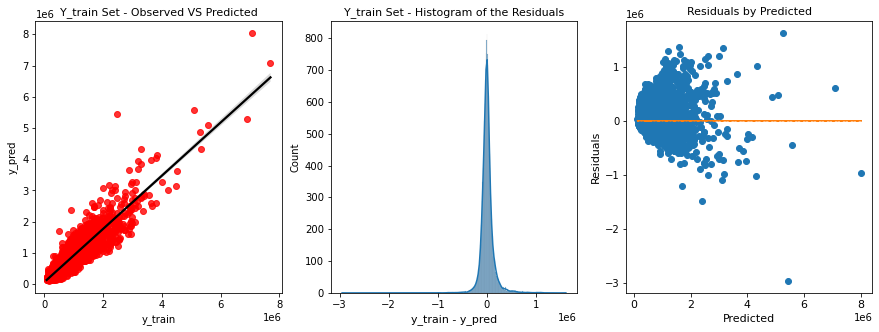

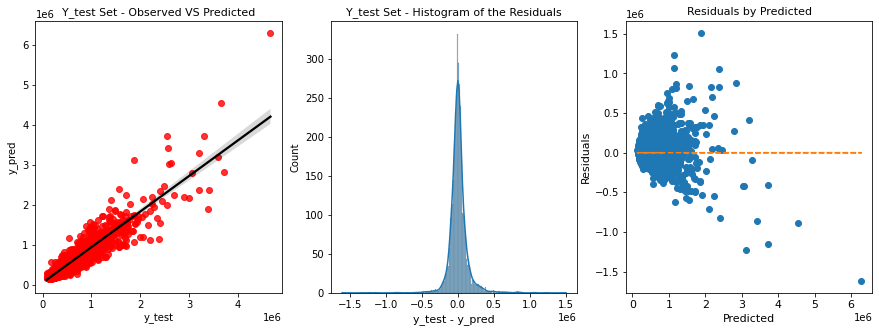

In [434]:
reg_m6_output = my_flex_regression(X_train_poly, y_train, X_test_poly, y_test, model = LinearRegression(), y_transformer="log")

## Model 7 - XGBoost

In [435]:
# Inputs for the Pipeline Controller

drop_columns = ["id", "date","sqft_lot", "sqft_above", "sqft_basement", "sqft_lot15", "condition", "floors", "sqft_living15"]
# cat_columns = ['waterfront', 'view', 'grade', 'renovated', 'zipcode']

In [436]:
# Pipeline Control

hp_df = (load_data("Data_MidTerm_Project_Real_State_Regression.xls")
.pipe(standard_headings)
.drop(drop_columns, axis=1)
.pipe(transform_renovated_built)
# .pipe(transform_age)
# .pipe(transform_renovated)
# .pipe(obj_to_cat, cat_columns)
.pipe(remove_rows)
.reset_index(drop=True)
)

In [437]:
# Logarithmic / Box- Plot Normalization

hp_df["price"] = np.log(hp_df["price"])
# hp_df["sqft_living"] = np.log(hp_df["sqft_living"])
# hp_df["sqft_living15"] = np.log(hp_df["sqft_living15"])

hp_df["sqft_living"] = var_normalization(hp_df["sqft_living"])[1]
# hp_df["sqft_living15"] = var_normalization(hp_df["sqft_living15"])[1]

In [438]:
# Location to Distance_to Transformation

latlong = hp_df[['long', 'lat']]
latlong["long_lat"] = list(zip(latlong['long'], latlong['lat']))
hp_df.insert(hp_df.shape[1]-1, 'dist_to_seattle', latlong['long_lat'].apply(haversine))
hp_df.insert(hp_df.shape[1]-1, 'dist_to_bellevue', latlong['long_lat'].apply(haversine, other=[-122.188985, 47.616492]))
# hp_df = hp_df.drop(["zipcode", "long", "lat"], axis=1)


C:\Users\ehern\AppData\Local\Temp/ipykernel_18644/1521038070.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  latlong["long_lat"] = list(zip(latlong['long'], latlong['lat']))


In [439]:
split_scaling_encoding_output = my_transformations(hp_df, test_size=0.2, scaler=None)

In [440]:
X_train = pd.concat([split_scaling_encoding_output["train"][0], split_scaling_encoding_output["train"][1].reset_index(drop=True)], axis=1)
y_train = split_scaling_encoding_output["train"][2].reset_index(drop=True)

X_test = pd.concat([split_scaling_encoding_output["test"][0], split_scaling_encoding_output["test"][1].reset_index(drop=True)], axis=1)
y_test = split_scaling_encoding_output["test"][2].reset_index(drop=True)

In [441]:
X_train

,bedrooms,bathrooms,sqft_living,waterfront,view,grade,age,zipcode,lat,long,dist_to_seattle,dist_to_bellevue
0,4,2.50,0.876559,0,0,7,14,98056,47.4814,-122.189,18.021269,15.021545
1,3,2.75,1.026851,0,0,10,18,98075,47.5879,-121.973,27.343937,16.502797
2,3,2.25,-0.650752,0,0,7,12,98027,47.5348,-122.072,21.491379,12.630265
3,3,1.75,-0.121692,0,0,7,35,98038,47.4109,-121.958,35.977650,28.697600
4,2,2.50,-0.297071,0,0,9,6,98119,47.6320,-122.361,3.122472,13.006352
...,...,...,...,...,...,...,...,...,...,...,...,...
17271,2,1.75,-0.989895,0,0,7,29,98033,47.6936,-122.186,14.642003,8.576933
17272,3,2.25,-1.514454,0,0,7,8,98117,47.6983,-122.367,10.149987,16.140336
17273,3,1.75,-0.626550,1,4,8,45,98023,47.3311,-122.375,31.081529,34.677334
17274,3,1.00,-1.246077,0,0,7,77,98125,47.7254,-122.290,13.356651,14.278039


In [442]:
y_train

0        12.959727
1        13.586097
2        12.866180
3        12.657148
4        13.748302
           ...    
17271    13.056224
17272    12.676076
17273    13.351887
17274    13.000196
17275    13.458836
Name: price, Length: 17276, dtype: float64

The model performance for the train set
-------------------------------------------
RMSE of train set is 98718.31541489411
Adjusted R2 score of train set is 0.9294449814641612

The model performance for the test set
-------------------------------------------
RMSE of test set is 108025.17077687016
Adjusted R2 score of test set is 0.9039452195982515


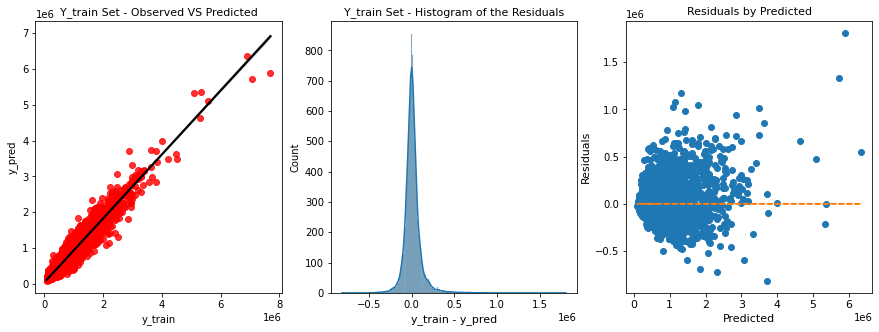

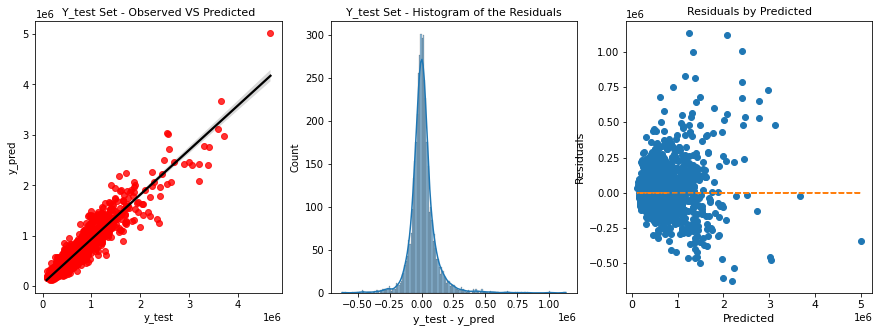

In [443]:
reg_m7_output = my_flex_regression(X_train, y_train, X_test, y_test, y_transformer = "log", model = xgboost.XGBRegressor(), n_estimators=90, learning_rate=0.1, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=6)